In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
import scienceplots
plt.style.use("science")
from pymatreader import read_mat
import IPython
from pathlib import Path
from utilities import savefig, FKFit, FitInput, FitResult, perform_fit, perform_fit_rounds, FK_fit
from iminuit import Minuit
from iminuit.cost import LeastSquares, BinnedNLL
from scipy.special import softmax
from scipy.stats import chi2
from scipy.optimize import curve_fit
from dataclasses import dataclass

In [2]:
NB_NAME = Path(IPython.extract_module_locals()[1]["__vsc_ipynb_file__"]).stem

In [3]:
# "VoltPowerScan_SNSPD_GaAs_SiO2___RT_scan_TMTE_20250114-153142_CTL_CW_0p02uW_200uW_0V_-5V.mat"

# DATAPATH = os.path.join(os.path.abspath(""), "data", NB_NAME, "VoltPowerScan_SNSPD_GaAs_SiO2___RT_scan_TMTE_20250114-153142_CTL_CW_0p02uW_200uW_0V_-5V.mat")
# data = read_mat(DATAPATH)["Data"]
DATAPATH = os.path.join(os.path.abspath(""), "data", NB_NAME)

fnames = os.listdir(DATAPATH)
fnames = [os.path.join(DATAPATH, fname) for fname in fnames]
data_dict = {}

for fname in fnames:
    data = read_mat(fname)["Data"]
    resistance = int(data["Resistance"])
    if (
        Path(fname).stem
        == "VoltPowerScan_SNSPD_GaAs_SiO2___RT_scan_TMTE_20250114-153142_CTL_CW_0p02uW_200uW_0V_-5V"
    ):
        data = {
            "counts": data["MeasureCounts"][:, :-6:5],
            "current": data["MeasureCurrent"][:, :-6:5] * 1e6,
            "M_power": data["MeasuredPower"] * 1e6,
        }
    else:
        voltagelist = data["VoltageList"]
        powerlist = data["PowerList"] * 1e6
        data = {
            "counts": data["MeasureCounts"],
            "current": data["MeasureCurrent"] * 1e6,
            "M_power": data["MeasuredPower"] * 1e6,
        }
    data_dict[resistance] = data

resistances = sorted(list(data_dict.keys()))

/home/ali/miniconda3/envs/university/lib/python3.11/site-packages/pymatreader/utils.py:291: UserWarning: Complex objects (like classes) are not supported. They are imported on a best effort base but your mileage will vary.
  warn(


In [4]:
def plot_2d_maps(data_dict, powerlist, voltagelist, resistances):
    for resistance in resistances:
        print(f"DATA FOR RESISTANCE: {resistance:,}")
        fig, (ax, ax1) = plt.subplots(1, 2, figsize=(11, 4))
        pcm = ax.contourf(voltagelist, powerlist, data_dict[resistance]["counts"], levels=len(voltagelist))
        cb = fig.colorbar(pcm, ax=ax, pad = 0.01)
        cb.set_label(r"Counts", fontsize=14)
        ax.set_xlabel(r"Voltage [$V$]", fontsize=14)
        ax.set_ylabel(r"Power [$\mu W$]", fontsize=14)

        pcm = ax1.contourf(voltagelist, powerlist, np.abs(data_dict[resistance]["current"]), levels=len(voltagelist))
        cb = fig.colorbar(pcm, ax=ax1, pad = 0.01)
        cb.set_label(r"Current [$\mu W$]", fontsize=14)
        ax1.set_xlabel(r"Voltage [$V$]", fontsize=14)
        ax1.set_ylabel(r"Power [$\mu W$]", fontsize=14)
        plt.show()

DATA FOR RESISTANCE: 0


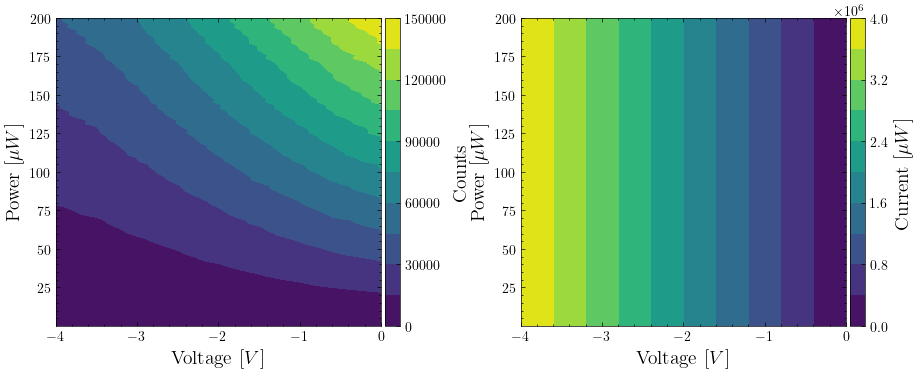

DATA FOR RESISTANCE: 97,500


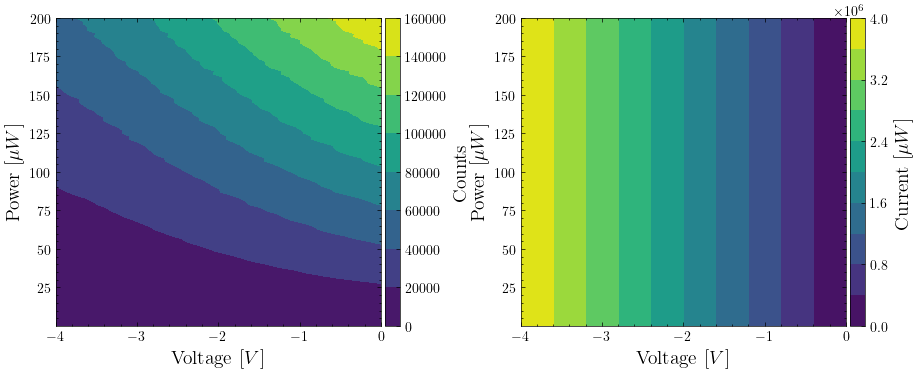

DATA FOR RESISTANCE: 325,300


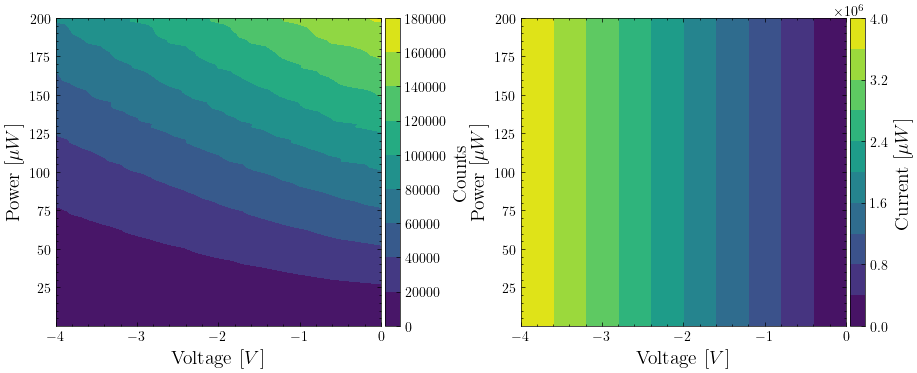

DATA FOR RESISTANCE: 552,000


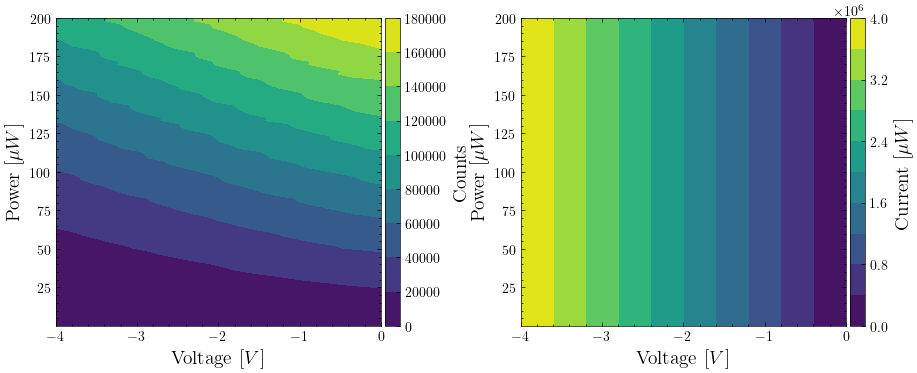

DATA FOR RESISTANCE: 677,000


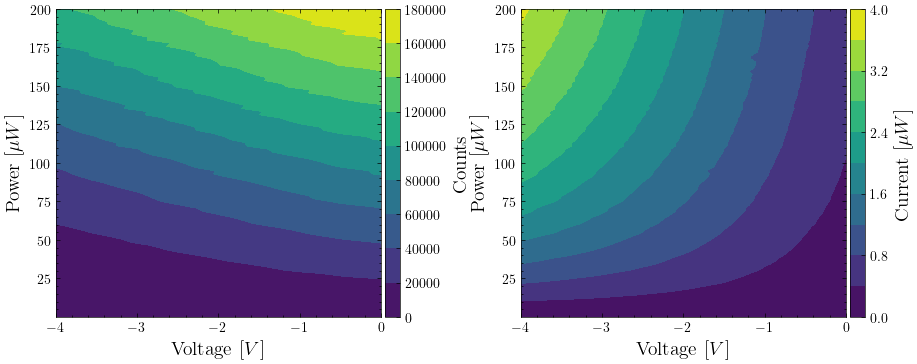

DATA FOR RESISTANCE: 807,000


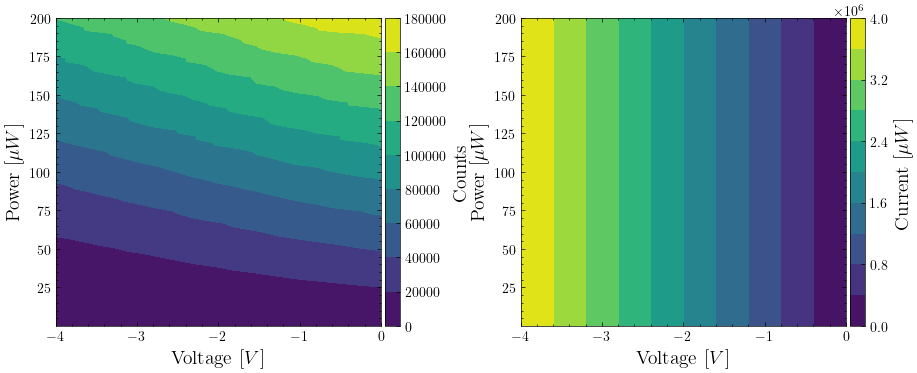

DATA FOR RESISTANCE: 1,000,000


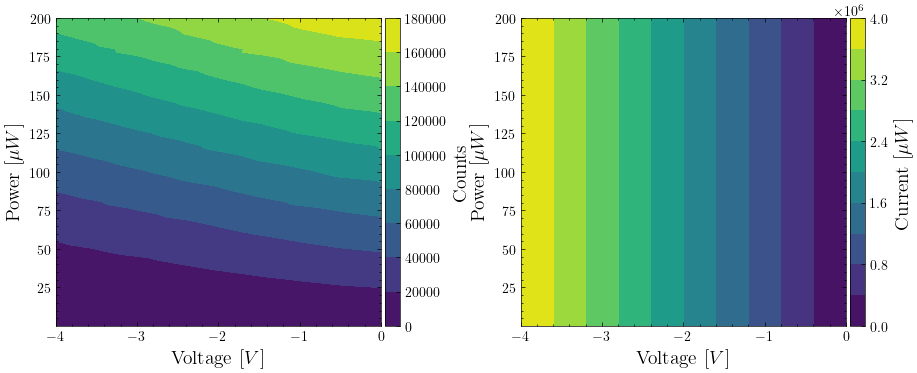

DATA FOR RESISTANCE: 3,012,000


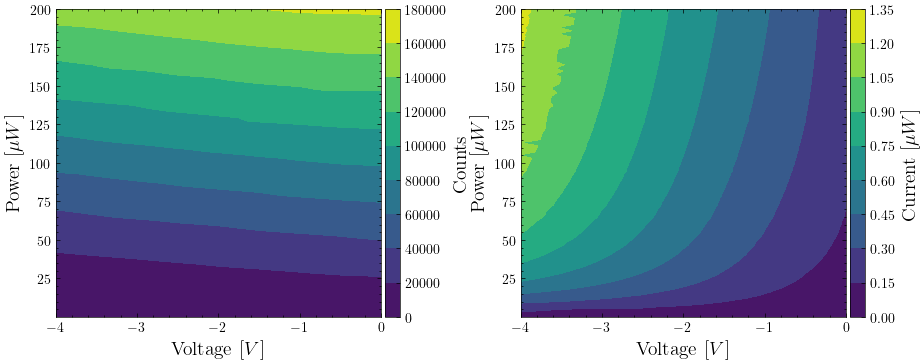

DATA FOR RESISTANCE: 10,000,000


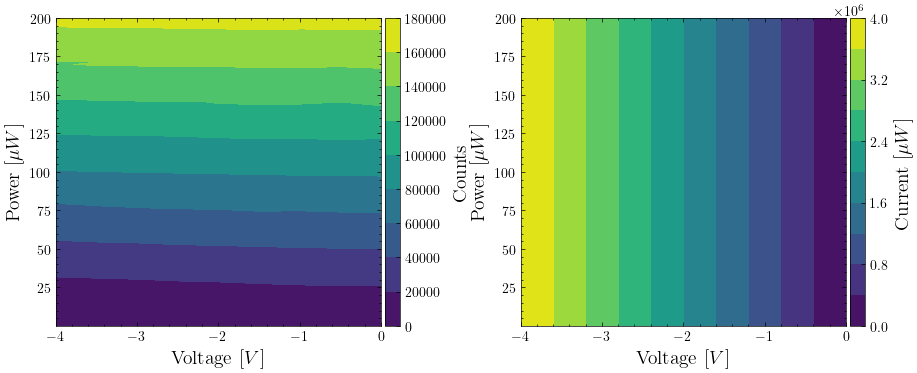

In [5]:
plot_2d_maps(data_dict, powerlist, voltagelist, resistances)

In [6]:
power_num = 50

def linear2(V_d: np.ndarray, T_0: float, g: float):
    alpha = FK_fit(2.99792458e5 / 321.5, 0, 298, V_d)
    return T_0 * np.exp(- g * alpha)

lin2_fit_result = perform_fit(FitInput(voltagelist, data_dict[0]["counts"][power_num], np.sqrt(data_dict[0]["counts"][power_num]), linear2, [14000, 1.2e-3]))
voltage_lin = np.linspace(0, -4, 1000)

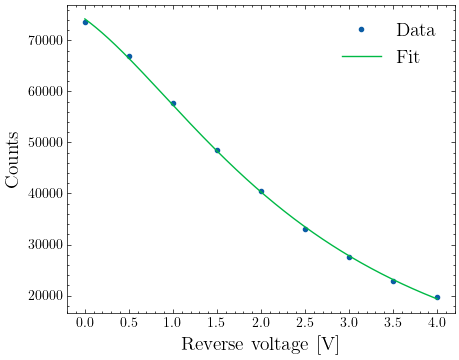

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(5,4))
ax.plot(np.abs(voltagelist), data_dict[0]["counts"][power_num], '.', label="Data")
ax.plot(np.abs(voltage_lin), linear2(voltage_lin, *lin2_fit_result.parameters), label="Fit")
ax.set_xlabel(r"Reverse voltage [V]", fontsize=14)
ax.set_ylabel(r"Counts", fontsize=14)
ax.legend(frameon=False, fontsize=14)
ax.legend(fontsize=14)
# savefig(NB_NAME, "voltage_counts_fit_100muW", fig)
plt.show()

In [8]:
print(f"g=Gamma*L calculations:\n{lin2_fit_result.parameters[1]}")

g=Gamma*L calculations:
0.0015566610020618394


In [9]:
gamma_lin2 = lin2_fit_result.parameters[1] / 3.5e-3
print(f"Gamma calculations:\n{gamma_lin2}")

Gamma calculations:
0.44476028630338266


In [10]:
gamma_vals = []
T_0_vals = []
b_vals = []

for power_idx in range(1, len(data_dict[0]["counts"])):
    fit_result_pow = perform_fit(
        FitInput(
            voltagelist,
            data_dict[0]["counts"][power_idx],
            10 * np.sqrt(data_dict[0]["counts"][power_idx]),
            linear2,
            [14000, 1.2e-3],
        )
    )
    if not(fit_result_pow.success):
        print(f"Fit at index {power_idx} was not completely successful!")
    gamma_vals.append(fit_result_pow.parameters[1] / 3.5e-3)
    T_0_vals.append(fit_result_pow.parameters[0])


gamma_vals = np.array(gamma_vals)

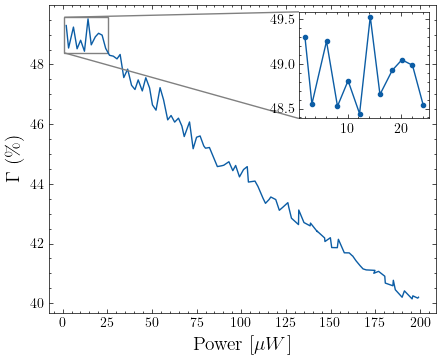

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(5,4))
ax.plot(data_dict[0]["M_power"][1:], 100 * gamma_vals)
ax.set_xlabel(r"Power [$\mu W$]", fontsize=14)
ax.set_ylabel(r"$\Gamma \ (\%)$", fontsize=14)
axins = zoomed_inset_axes(ax, zoom=3,loc=1)
axins.plot(data_dict[0]["M_power"][1:][0:12], 100 * gamma_vals[0:12], '.-')
mark_inset(ax, axins, loc1=2, loc2=3, fc="none", ec="0.5")
# savefig(NB_NAME, "gamma_pow", fig)
plt.show()

In [12]:
print(f"Gamma in %:\n{np.mean(100 * gamma_vals):.0f}%±{np.std(100 * gamma_vals):.0f}%")
print(f"Gamma in % (assuming good coupling):\n{np.mean(100 * gamma_vals[0:12]):.1f}%±{100 * np.std(gamma_vals[0:12]) / np.sqrt(12):.1f}%")

Gamma in %:
44%±3%
Gamma in % (assuming good coupling):
48.9%±0.1%


In [13]:
@dataclass
class NLResult:
    coeff: float
    coeff_pow: float
    deriv2: np.ndarray


def calculate_nl_coeff(fit_input: FitInput, fit_result: FitResult) -> np.ndarray:
    linspace = np.linspace(np.min(powerlist), np.max(powerlist), 1000)
    y_fit = fit_input.fit_func(linspace, *fit_result.parameters)
    deriv = np.gradient(y_fit, linspace, edge_order=2)
    deriv2 = np.gradient(deriv, linspace, edge_order=2)
    nl_coeff_idx = np.argmax(deriv2)
    if nl_coeff_idx == 0:
        nl_coeff = 0
    else:
        nl_coeff = deriv2[nl_coeff_idx]
    return NLResult(nl_coeff, linspace[nl_coeff_idx], deriv2)


def pv_power_counts_fit(
    data_dict: dict,
    resistance: int,
    voltages: np.ndarray,
    initial_guesses: list[float],
    softloss: bool = False,
    initial_guesses_feedback: bool = False,
) -> FitResult:
    counts = data_dict[resistance]["counts"]
    power = data_dict[resistance]["M_power"]
    error = np.sqrt(counts)

    fit_inputs = []
    fit_results = []
    nl_results = []
    # nl_coeffs = []
    # nl_idc = []
    # nl_derivs2 = []

    L = 3.5e-3  # Waveguide length in cm
    wl = 2.99792458e5 / 321.5  # Frequency in Thz to wavelength in nm
    T = 298  # Temperature in Kelvin

    for idx, voltage in enumerate(voltages):
    # for idx in range(len(voltages) - 1, -1, -1):
        # voltage = voltages[idx]
        fk_fit = FKFit(power, resistance * 1e-6, L, wl, 0.3, T, voltage)
        fit_func = fk_fit.FK_fit_power_scaled

        if (not initial_guesses_feedback) or (idx == 0):
        # if (not initial_guesses_feedback) or (idx == (len(voltages) - 1)):
            fit_input = FitInput(
                power,
                counts[:, idx],
                error[:, idx],
                fit_func,
                initial_guesses,
                # [0.02, -300, 1000],
            )
        else:
            fit_input = FitInput(
                power,
                counts[:, idx],
                error[:, idx],
                fit_func,
                fit_input.initial_guesses,
            )

        fit_result = perform_fit_rounds(fit_input, opt_rounds=10, softloss=softloss)
        nl_result = calculate_nl_coeff(fit_input, fit_result)

        fit_inputs.append(fit_input)
        fit_results.append(fit_result)
        nl_results.append(nl_result)

        print(fit_result.parameters)

        if not fit_result.success:
            print(
                f"Fit with resistance {resistance} and voltage {voltage} was not completely successful."
            )
    return fit_inputs, fit_results, nl_results
    # return fit_inputs[::-1], fit_results[::-1], nl_results[::-1]

In [ ]:
def plot_power_counts_with_fit(inputs, results, voltagelist):

    fig, axs = plt.subplots(3, 3, figsize=(25, 20))

    for idx, ax in enumerate(axs.ravel()):
        ax.set_title(rf"{voltagelist[idx]:.1f} $V$", fontsize=15)
        ax.plot(inputs[idx].xdata, inputs[idx].ydata, ".", label=f"Data")
        linspace = np.linspace(np.min(powerlist), np.max(powerlist), 1000)
        ax.plot(
            linspace,
            inputs[idx].fit_func(linspace, *results[idx].parameters),
            label=f"Fit",
            lw=2,
        )
        ax.legend(frameon=False, fontsize=13)

    fig.text(0.5, 0.06, r"Power [$\mu W$]", ha="center", fontsize=30)
    fig.text(0.09, 0.5, "Counts", va="center", rotation="vertical", fontsize=30)
    plt.show()


def fit_and_plot_for_resistance(
    data_dict: dict,
    voltagelist: np.ndarray,
    resistance: float,
    initial_guesses: list[float],
    softloss=False,
    initial_guesses_feedback=False,
):
    print(f"PLOTS FOR RESISTANCE {resistance:,}")
    fit_inputs, fit_results, nl_results = pv_power_counts_fit(
        data_dict,
        resistance,
        voltagelist,
        initial_guesses,
        softloss=softloss,
        initial_guesses_feedback=initial_guesses_feedback,
    )

    plot_power_counts_with_fit(fit_inputs, fit_results, voltagelist)

    max_derivs = []
    max_nl_power = []

    plt.figure(figsize=(7, 5))
    for idx in range(len(fit_inputs)):
        nl_result = nl_results[idx]
        linspace = np.linspace(powerlist[0], powerlist[-1], 1000)
        max_derivs.append(nl_result.coeff)
        max_nl_power.append(nl_result.coeff_pow)
        plt.plot(linspace, nl_result.deriv2, label=f"{voltagelist[idx]}V")
    plt.xlabel(r"Power [$\mu$W]", fontsize=17)
    plt.ylabel(r"Second derivative of counts", fontsize=17)
    plt.legend()
    plt.show()

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 4))
    ax1.plot(np.abs(voltagelist), max_derivs, ".-")
    ax1.set_xlabel("Reverse bias voltage", fontsize=14)
    ax1.set_ylabel("Non-linearity coefficient", fontsize=14)
    ax2.set_xlabel(r"Reverse bias voltage [$V$]", fontsize=14)
    ax2.set_ylabel("Power at peak non-linearity [$\mu W$]", fontsize=14)
    ax2.plot(np.abs(voltagelist), max_nl_power, ".-")
    plt.show()

    return np.max(max_derivs), voltagelist[np.argmax(max_derivs)]

In [57]:
max_deriv_res = []
max_nl_voltage_res = []

PLOTS FOR RESISTANCE 97,500
[0.4598769772926719, 51.55419583126827, 951.6875797928722]
Fit with resistance 97500 and voltage 0.0 was not completely successful.
[0.3202139730593382, 57.04452414964245, 931.3865005373052]
Fit with resistance 97500 and voltage -0.5 was not completely successful.
[0.34017362347273655, 67.13820382221019, 899.5389524556631]
[0.11822108774872055, 58.07022003337973, 927.5632391438165]
[0.10015059230808182, 57.24212409201995, 930.7715190735609]
[0.09618390811680573, 57.83668976094783, 928.8414828619129]
[0.09805699581704683, 59.342813970760076, 923.9118660341726]
[0.10058388204370379, 61.16899643898984, 917.9673156993072]
[0.09644133587922496, 57.022053323693534, 931.0401122321512]
Fit with resistance 97500 and voltage -4.0 was not completely successful.


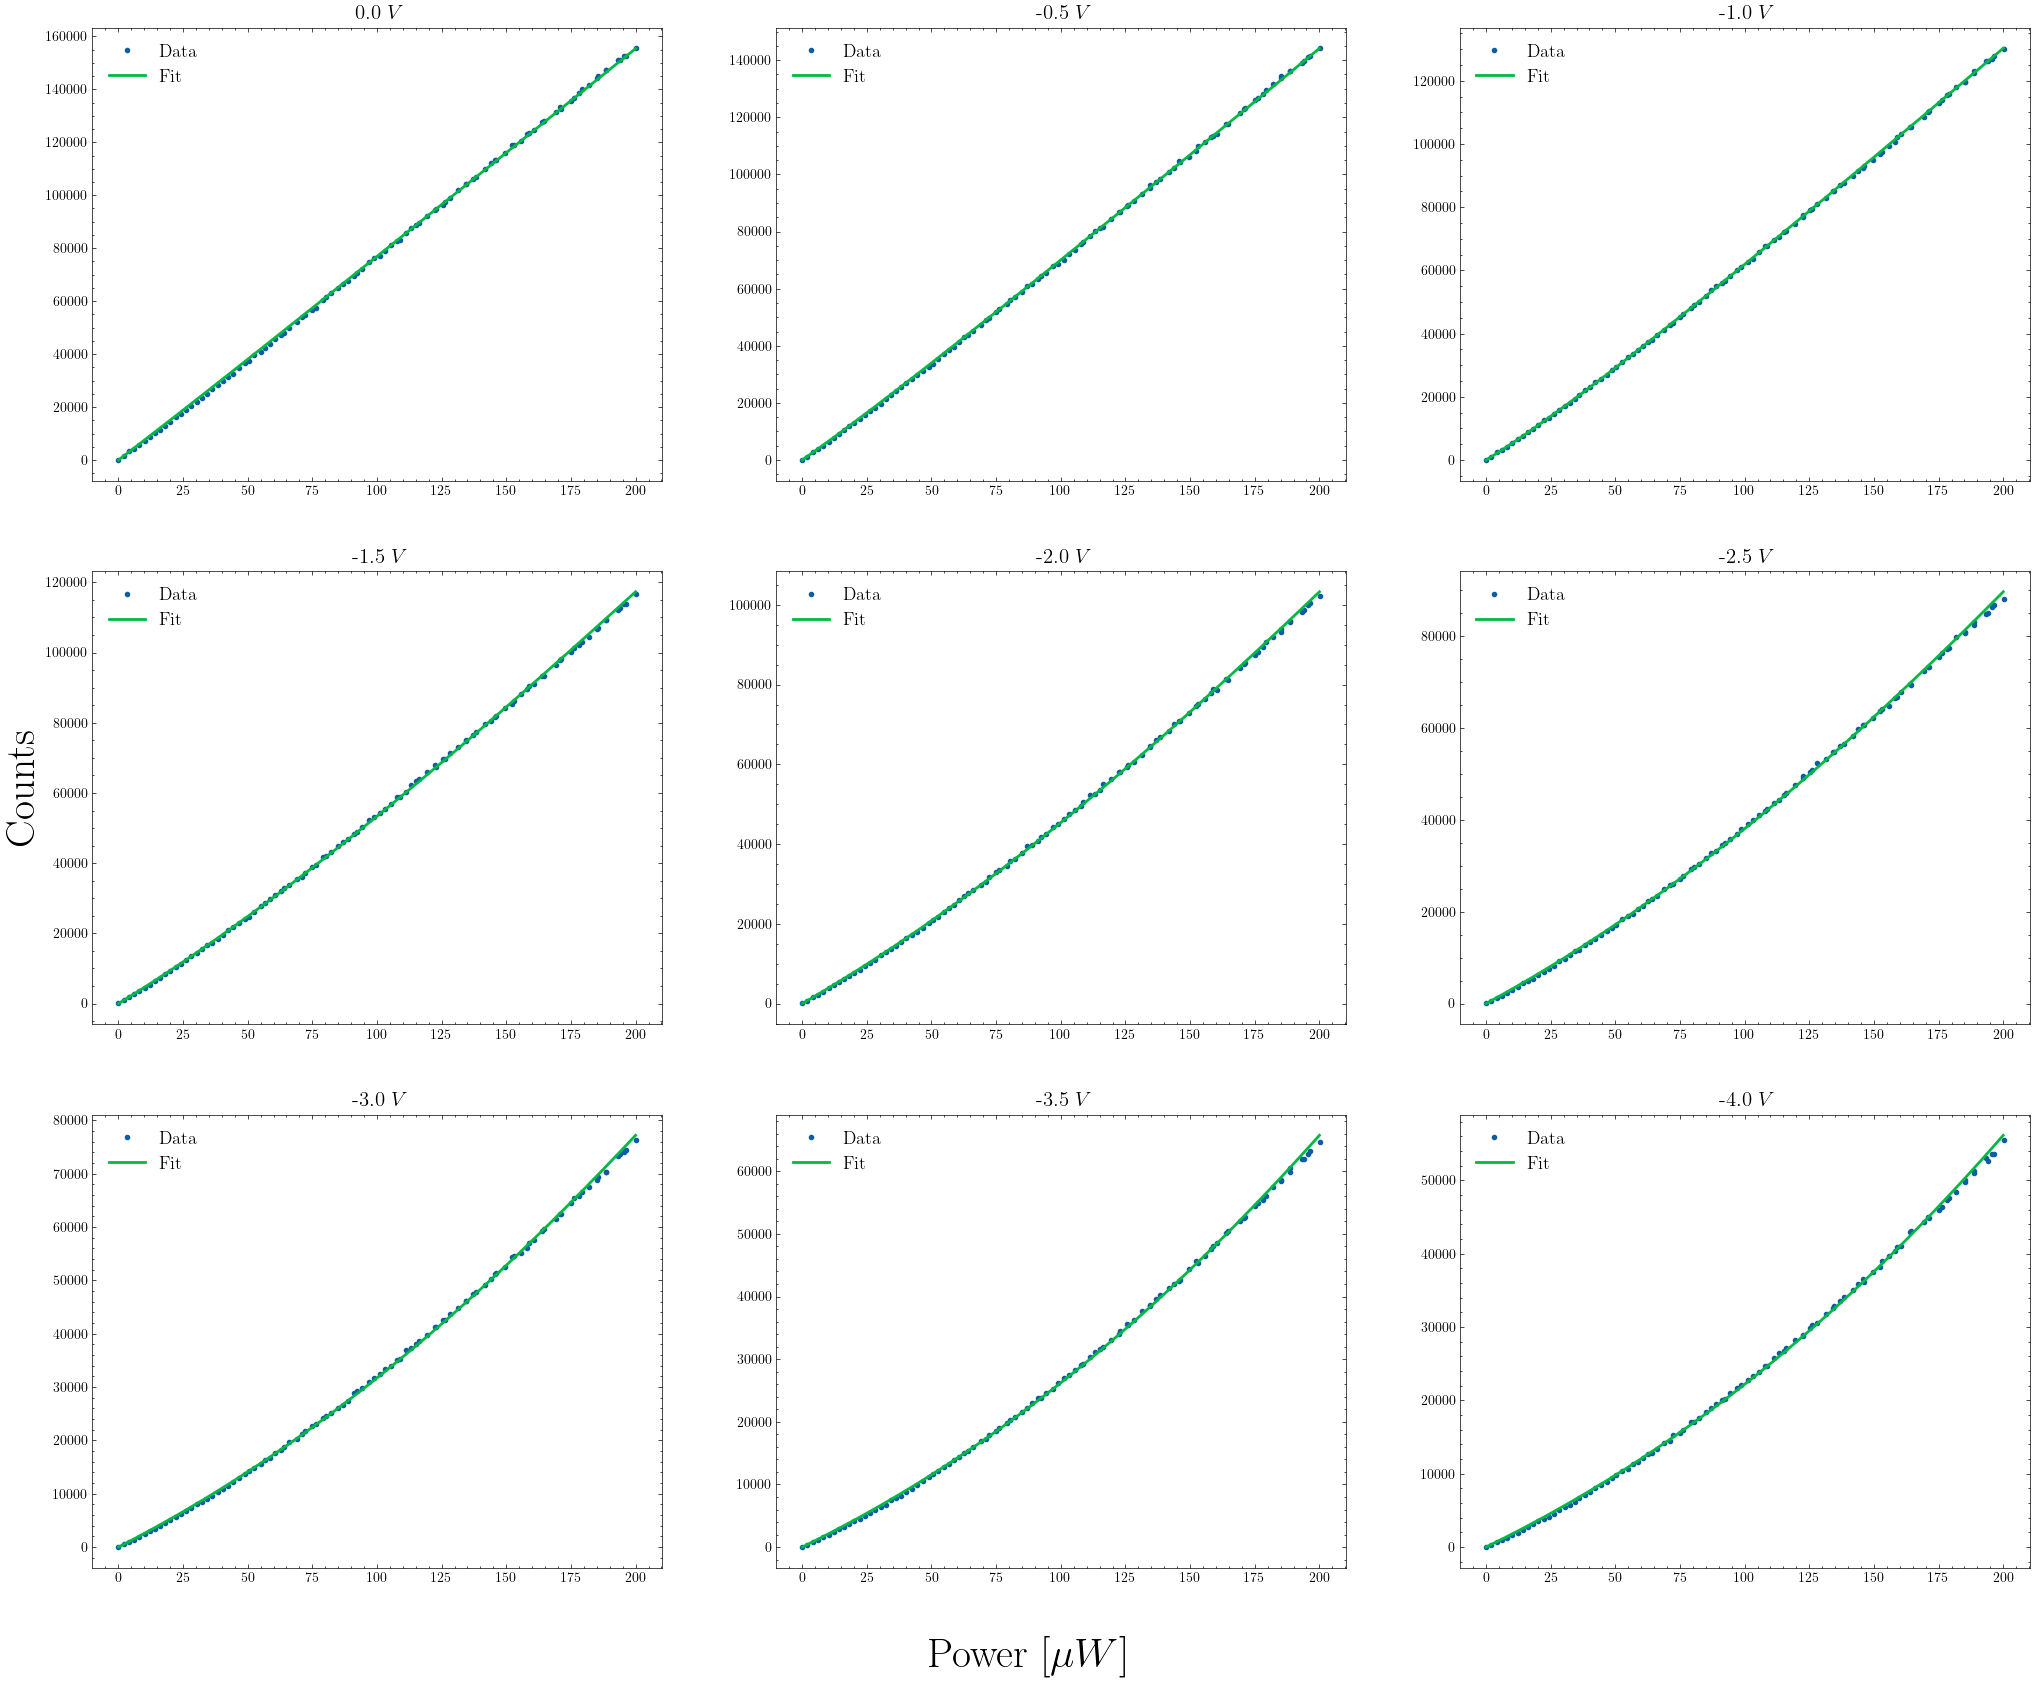

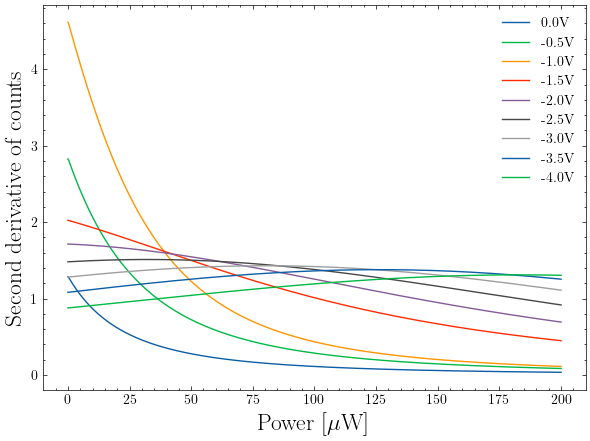

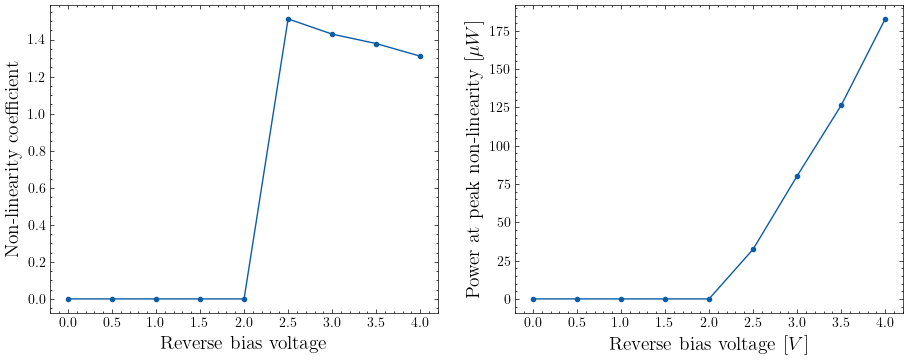

PLOTS FOR RESISTANCE 325,300
[0.13080715719456285, 39.1878341505223, 938.3602117230298]
[0.08544399801590831, 40.83661149783438, 933.0174959549639]
Fit with resistance 325300 and voltage -0.5 was not completely successful.
[0.07360925837208111, 43.677520259433614, 923.7458462779367]
[0.0701120087921462, 46.751000269991174, 913.8181327481497]
Fit with resistance 325300 and voltage -1.5 was not completely successful.
[0.07088503598613949, 49.74616583125451, 901.4950974304945]
[0.0711716015364218, 52.90504564539767, 891.5422387946996]
[0.0722841339428394, 56.31359002661287, 878.9130635007772]
[0.06632552127635895, 53.876733937159095, 886.6986431317952]
[0.06286438724301724, 50.667328052171996, 896.7466826994753]


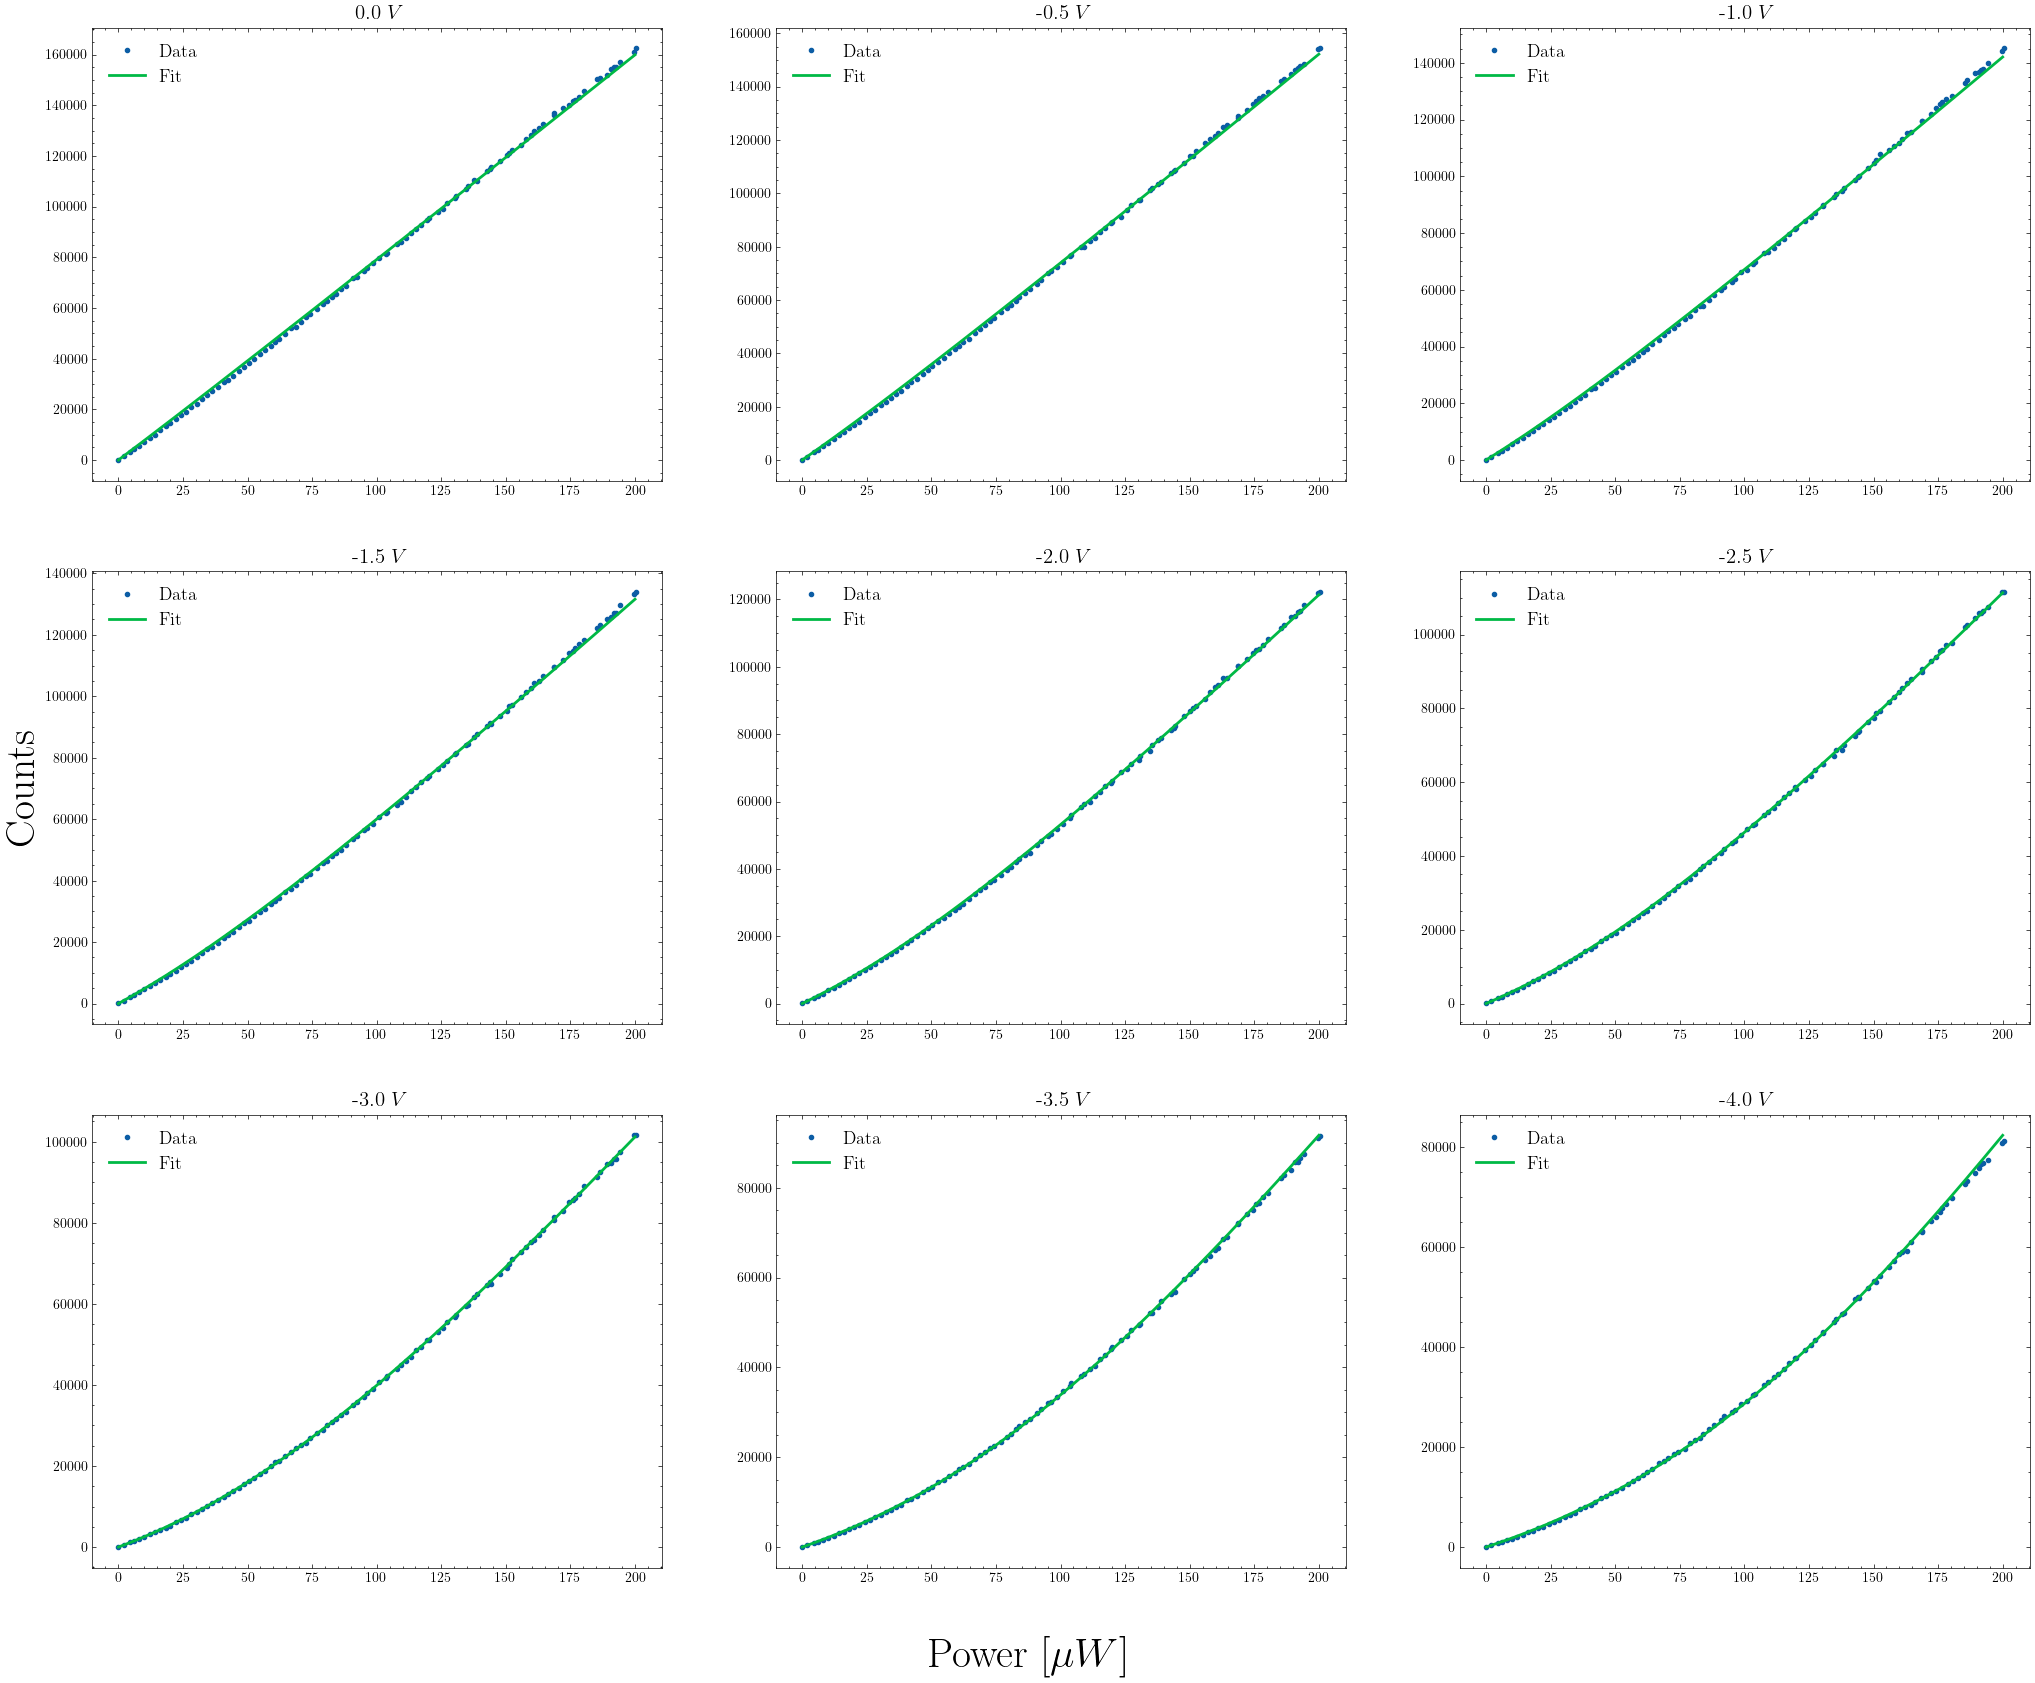

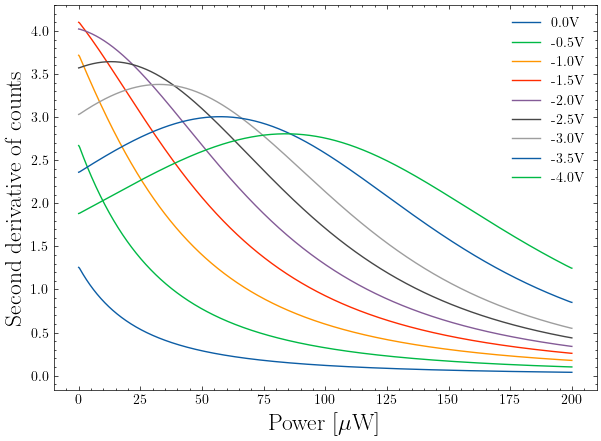

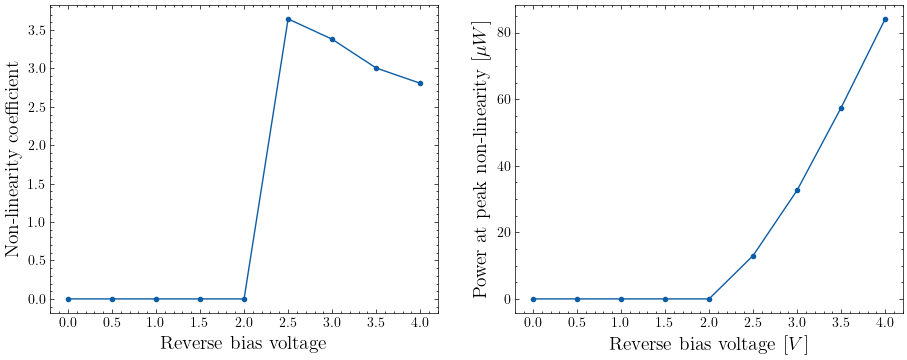

PLOTS FOR RESISTANCE 552,000
[0.07743909434719459, 21.845206380677386, 972.284335818853]
Fit with resistance 552000 and voltage 0.0 was not completely successful.
[0.05098580622799378, 21.34828839308449, 974.0001207821457]
Fit with resistance 552000 and voltage -0.5 was not completely successful.
[0.043665817119741206, 21.274105693913167, 974.277335302702]
[0.04280180754604113, 21.63812232739313, 973.0324846333759]
Fit with resistance 552000 and voltage -1.5 was not completely successful.
[0.04472038588658449, 23.155950203222023, 967.8503627454932]
[0.04995149537535719, 27.045525415895007, 954.6966898710897]
[0.05474199830910899, 31.69945821346786, 939.0906235142688]
[0.05852352897196495, 36.2267732864043, 924.0797588440987]
[0.06002525630388668, 39.10131429700804, 914.5708578148566]
Fit with resistance 552000 and voltage -4.0 was not completely successful.


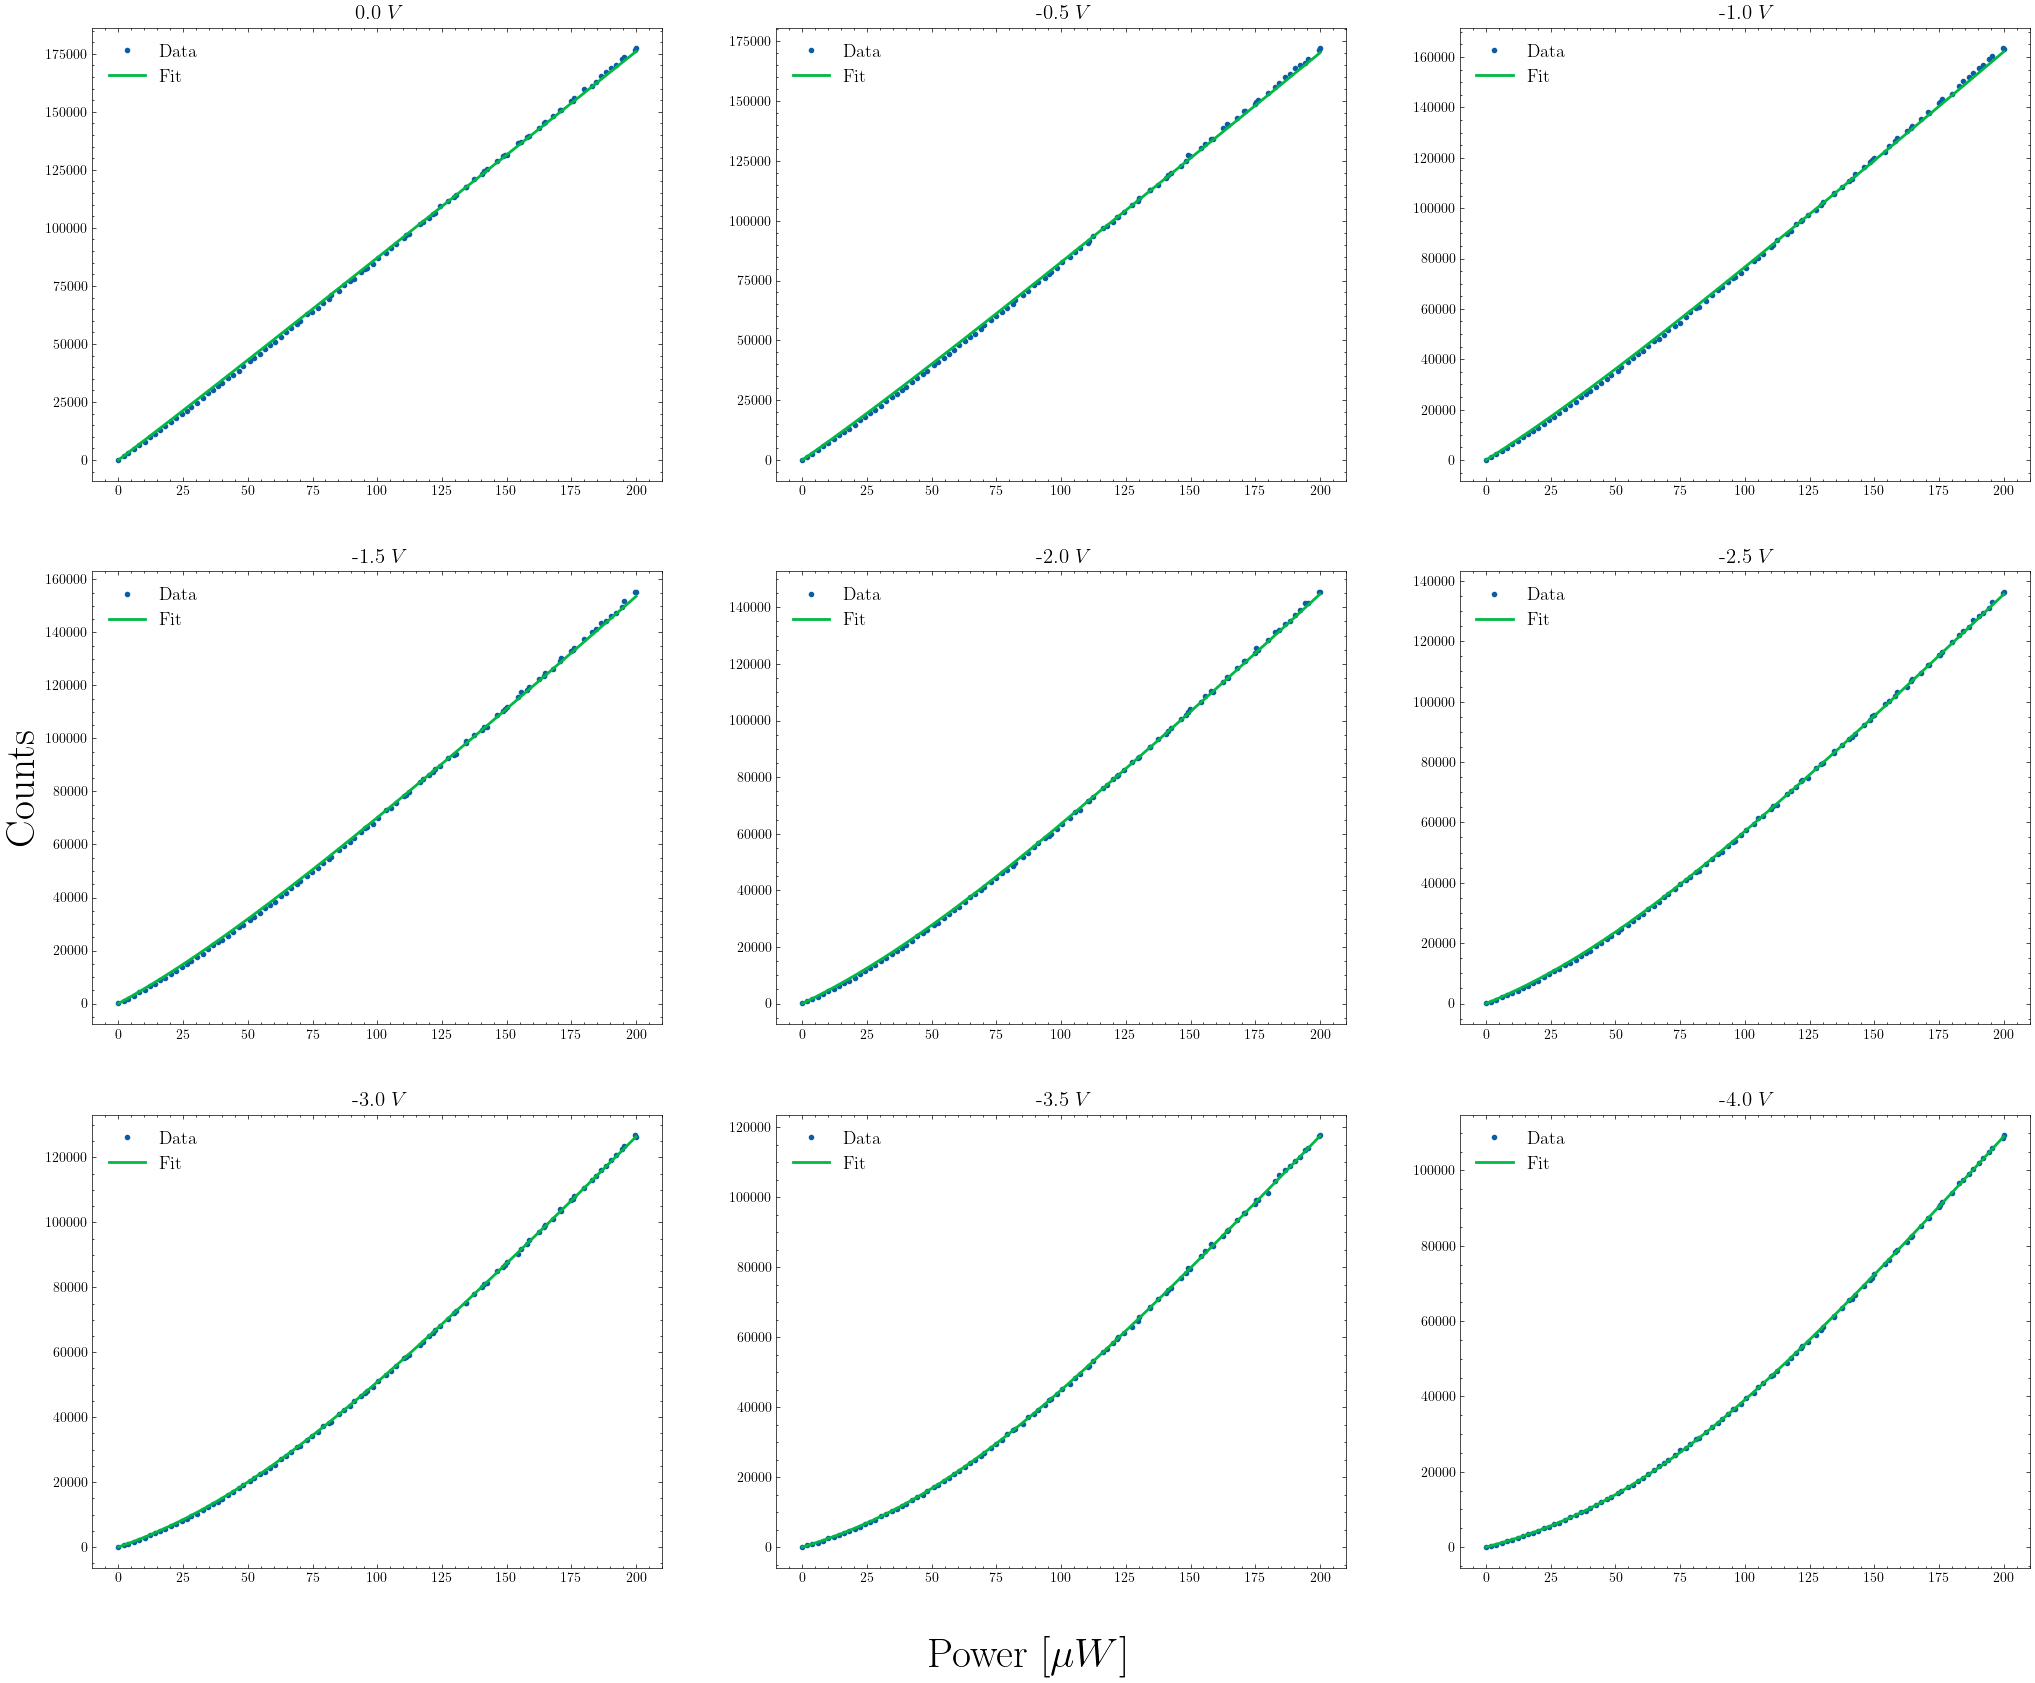

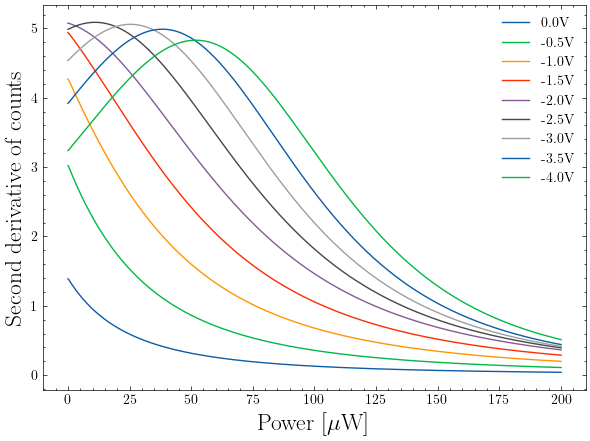

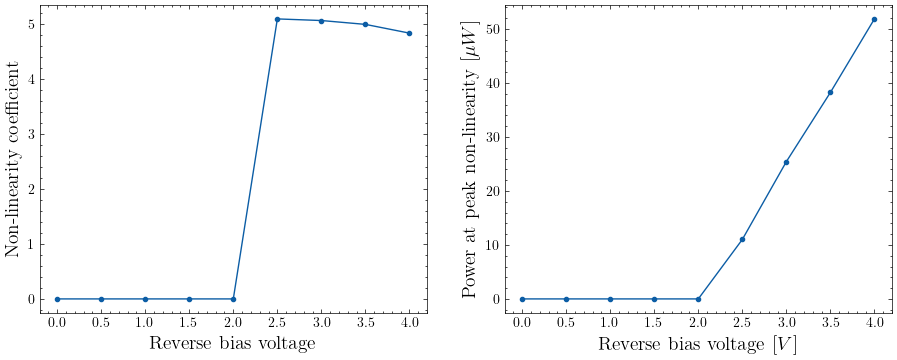

PLOTS FOR RESISTANCE 677,000
[0.06282912197996421, 21.754965866921278, 972.5901285116645]
Fit with resistance 677000 and voltage 0.0 was not completely successful.
[0.041189414411667576, 20.179874165692038, 977.9972588563708]
[0.03573271207398285, 18.700777442177014, 983.0670874008218]
Fit with resistance 677000 and voltage -1.0 was not completely successful.
[0.03498047760485478, 17.813465971723346, 986.1009698069029]
Fit with resistance 677000 and voltage -1.5 was not completely successful.
[0.03684008815621325, 18.384848920795747, 984.1562508049786]
Fit with resistance 677000 and voltage -2.0 was not completely successful.
[0.042423397195549946, 22.19825845267439, 971.4932223582629]
Fit with resistance 677000 and voltage -2.5 was not completely successful.
[0.046834968127553944, 26.014070297266404, 958.6160281276444]
[0.05001223347282581, 29.405435260919273, 947.2655807863495]
[0.052641806247448124, 32.739843717639495, 936.2149595495363]


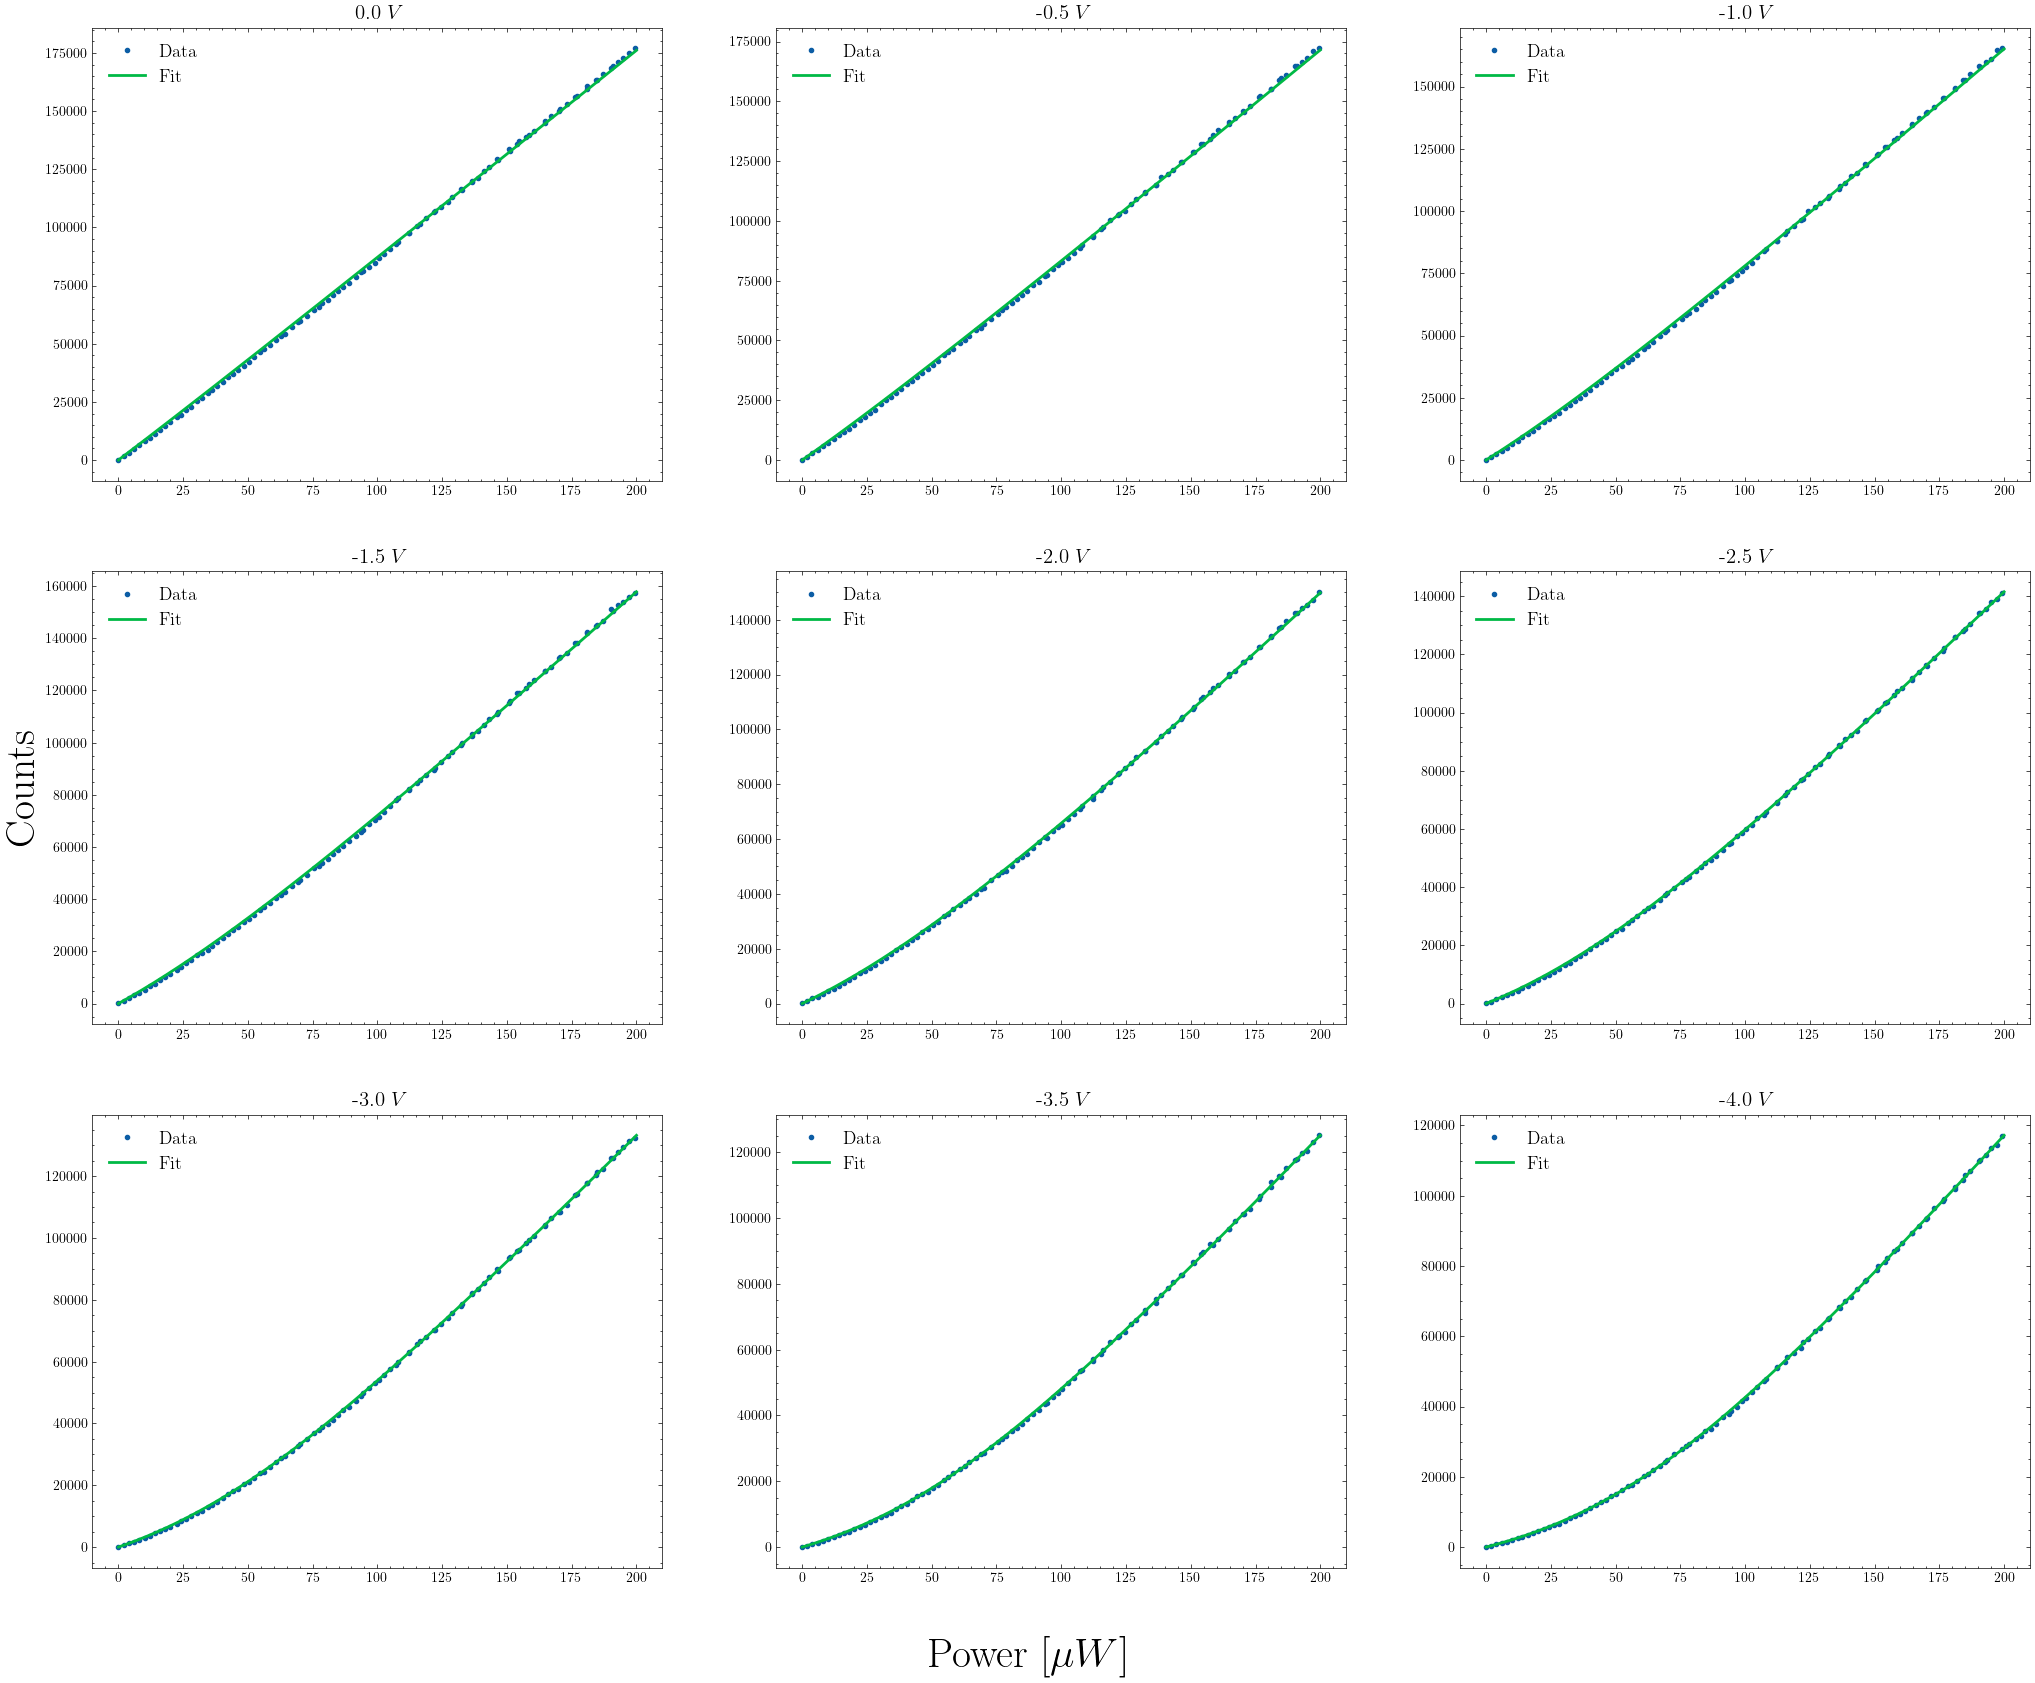

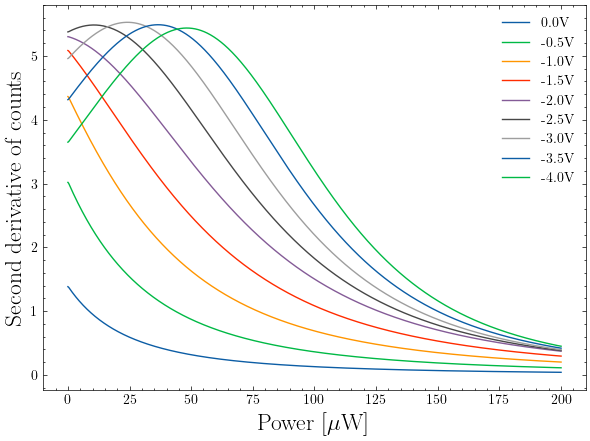

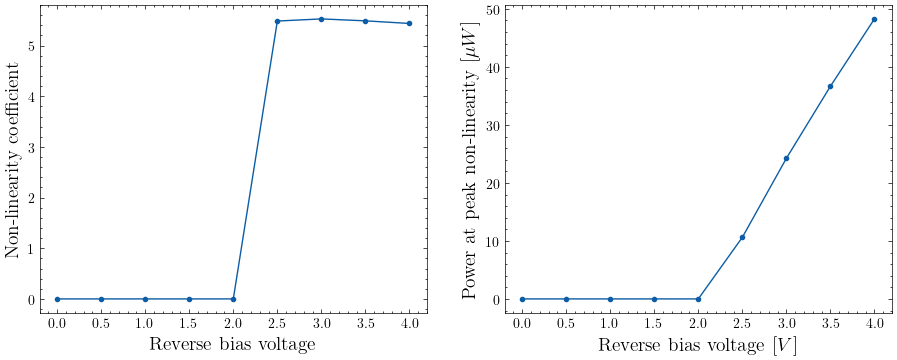

PLOTS FOR RESISTANCE 807,000
[0.05363605592543033, 26.136667145761486, 960.2096356381265]
Fit with resistance 807000 and voltage 0.0 was not completely successful.
[0.03464270711396215, 24.071632618506438, 967.175166004128]
Fit with resistance 807000 and voltage -0.5 was not completely successful.
[0.03063754032928945, 22.24724032483833, 973.3209860691676]
Fit with resistance 807000 and voltage -1.0 was not completely successful.
[0.030707115972406832, 21.136988905557203, 977.0455828989993]
Fit with resistance 807000 and voltage -1.5 was not completely successful.
[0.03406103314133454, 22.111856722797945, 973.9135539017036]
[0.038990241672912124, 25.35383847787459, 963.3156485882303]
[0.04430438864164562, 29.691597737013577, 948.9617314869649]
[0.04886196436141661, 34.30155911621736, 933.7310943579868]
[0.05187355194423102, 37.996485279567416, 921.6607761619815]


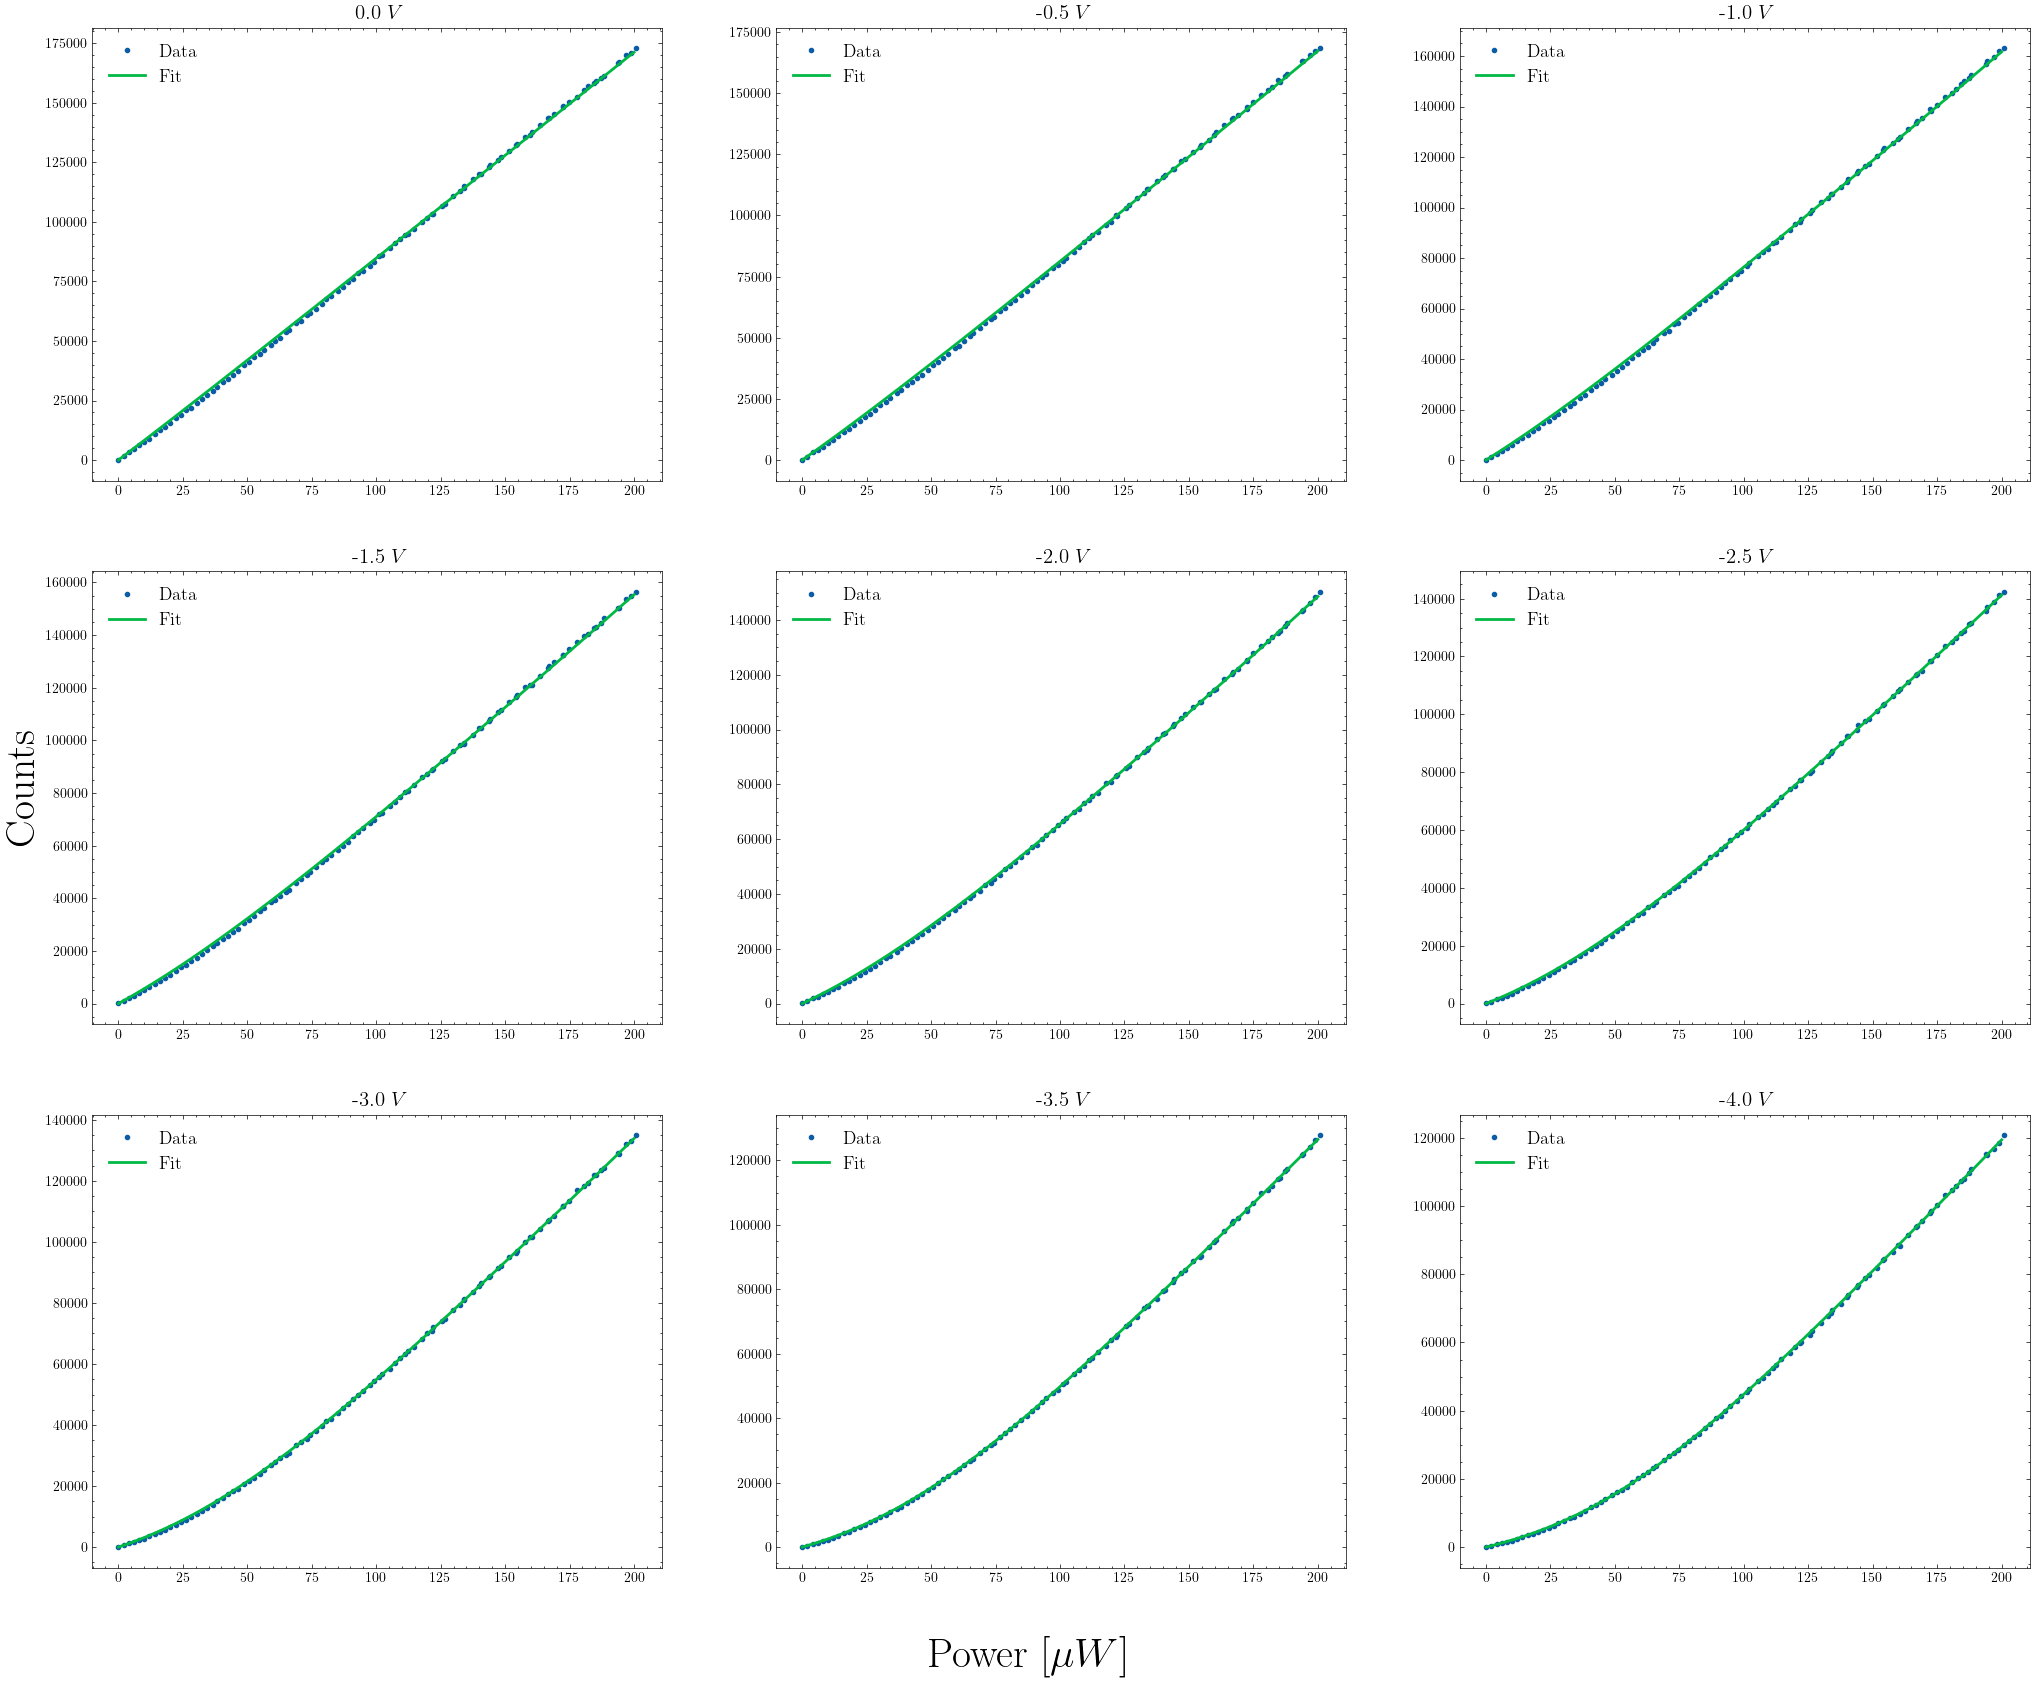

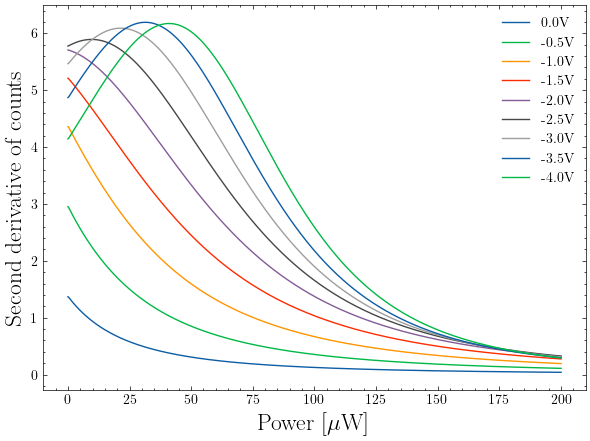

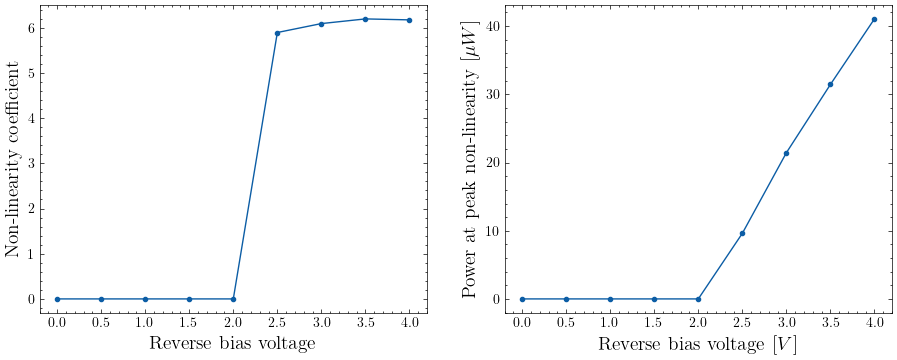

PLOTS FOR RESISTANCE 1,000,000
[0.04600948444860456, 23.23398057719313, 968.4663506385936]
Fit with resistance 1000000 and voltage 0.0 was not completely successful.
[0.030145917502919273, 20.841289122472123, 976.5608310629177]
[0.02683169222729175, 18.70761919048824, 983.7630116938291]
Fit with resistance 1000000 and voltage -1.0 was not completely successful.
[0.029069101633090372, 18.29517007237743, 985.0980799579345]
Fit with resistance 1000000 and voltage -1.5 was not completely successful.
[0.032052182402045985, 19.185138065152874, 982.1826123649709]
Fit with resistance 1000000 and voltage -2.0 was not completely successful.
[0.03755026955600686, 22.950561631825686, 969.7247806156599]
[0.041964633731703775, 26.524696967038956, 957.7255919029128]
[0.04519570145182757, 29.94275550349573, 946.2654048258]
[0.04873640371453823, 34.191897494919665, 932.1984230514474]


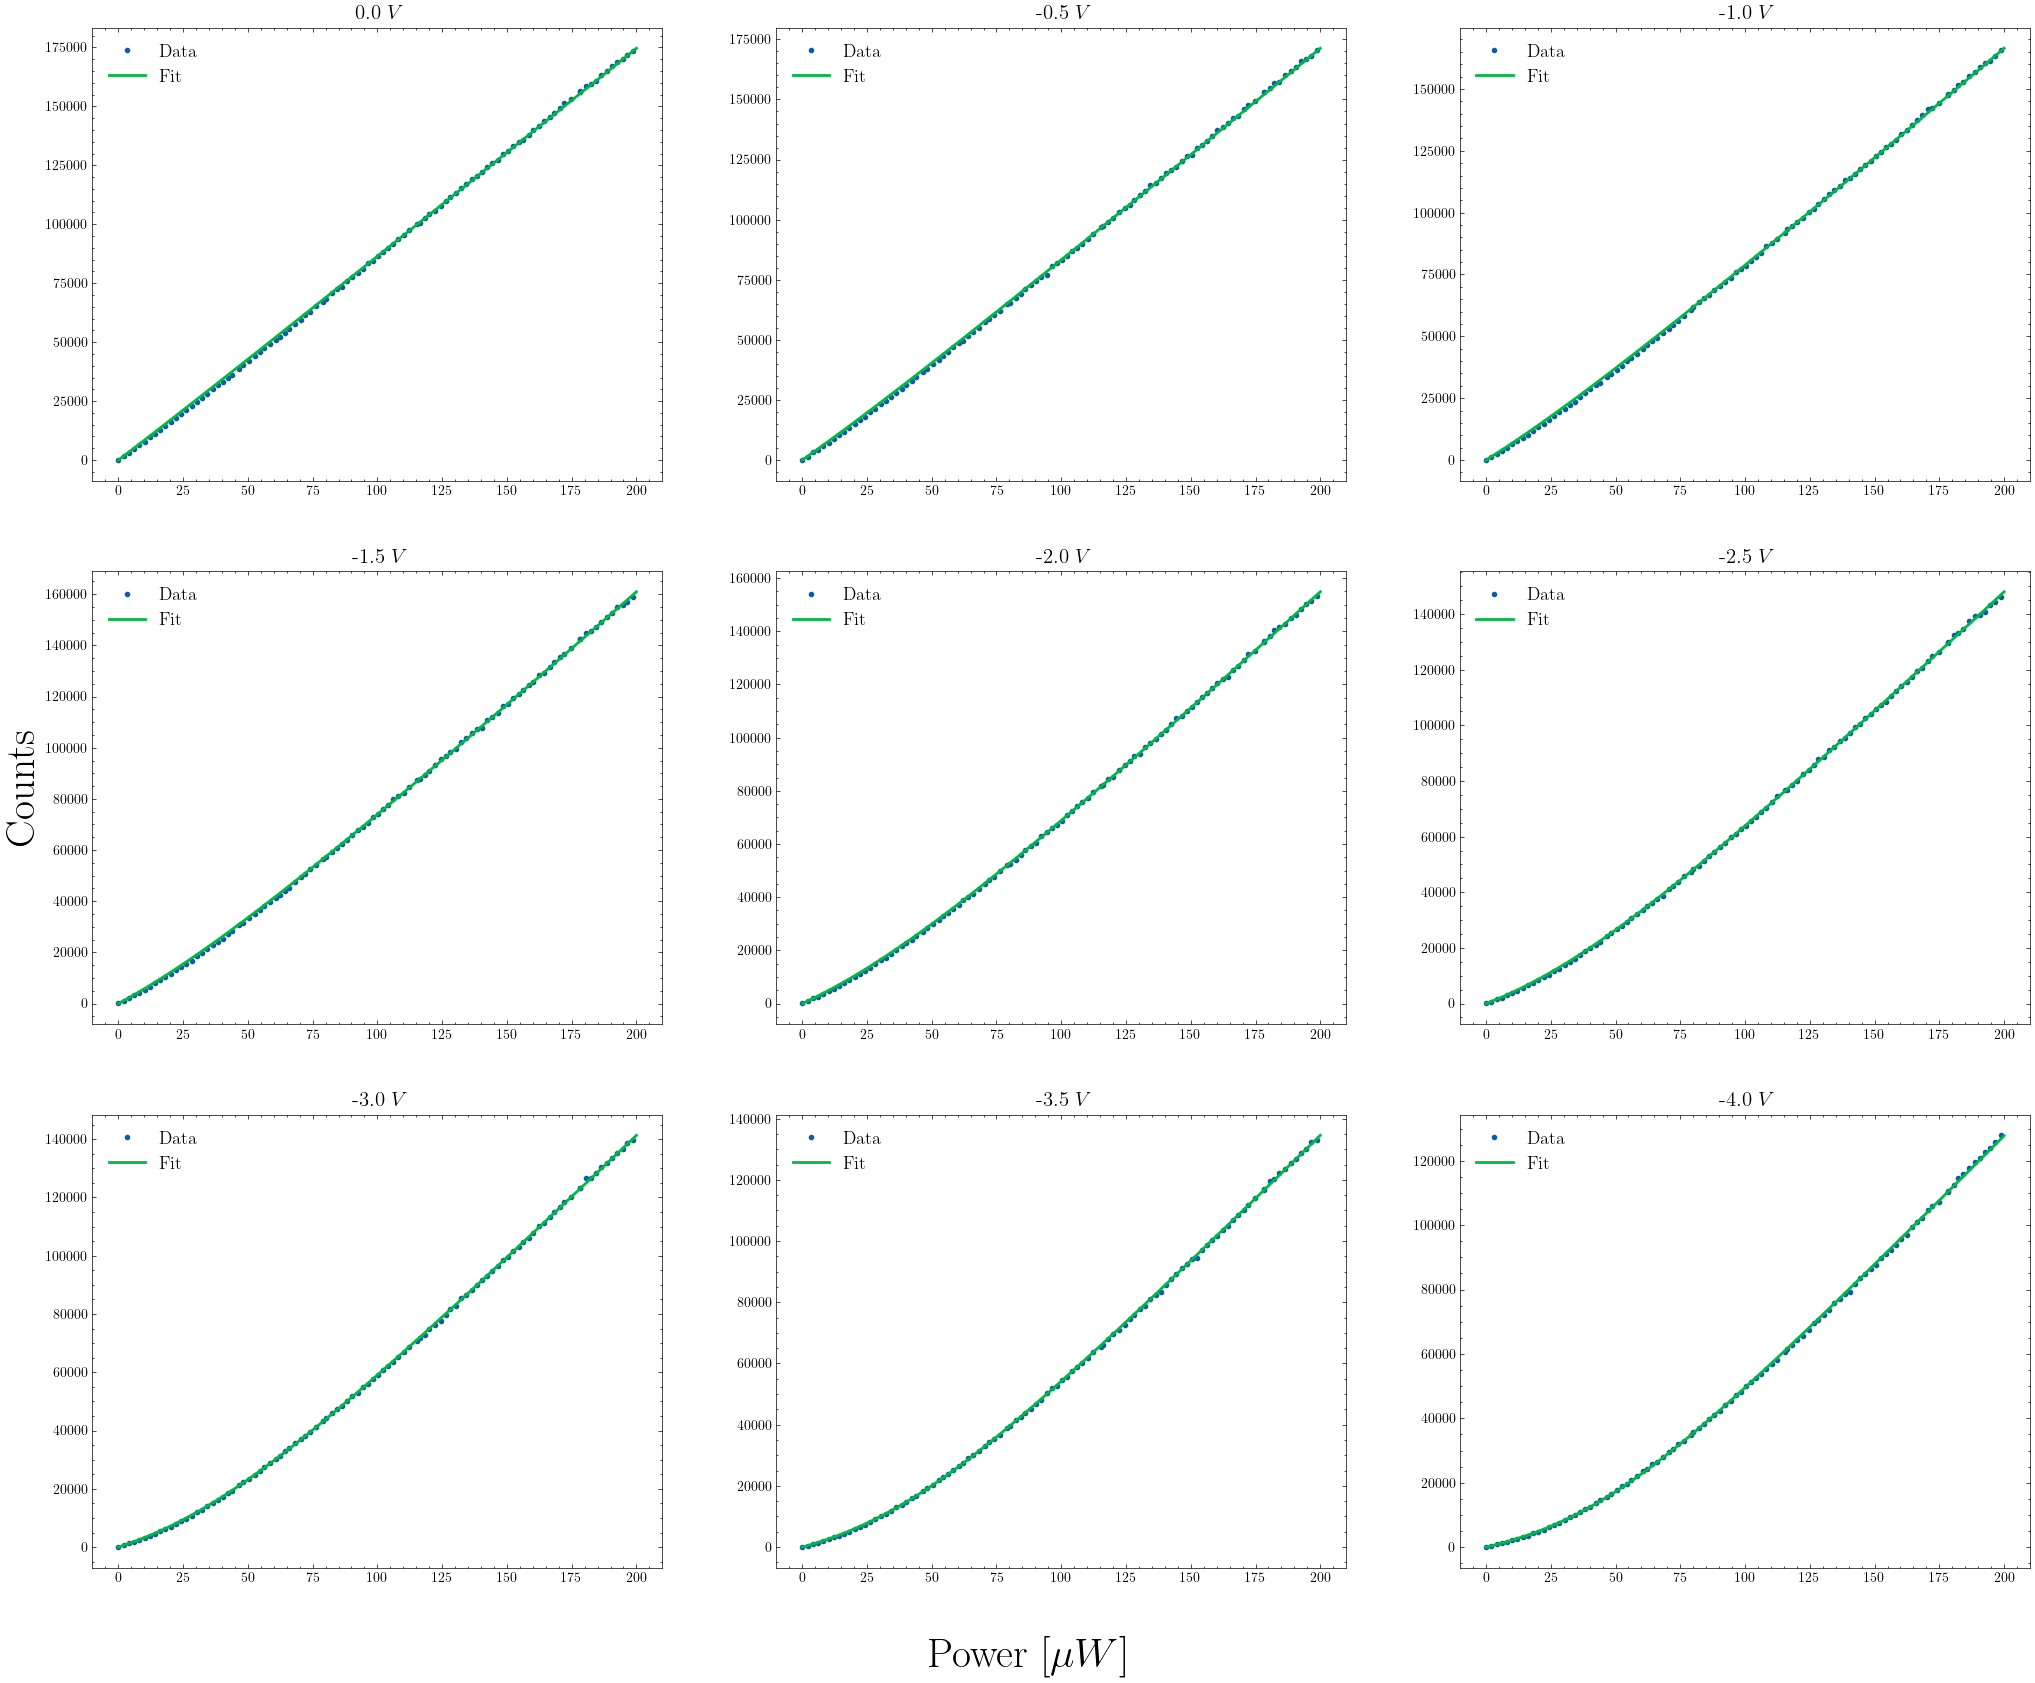

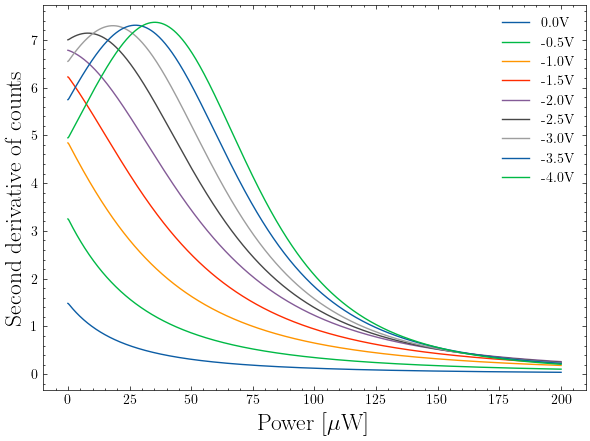

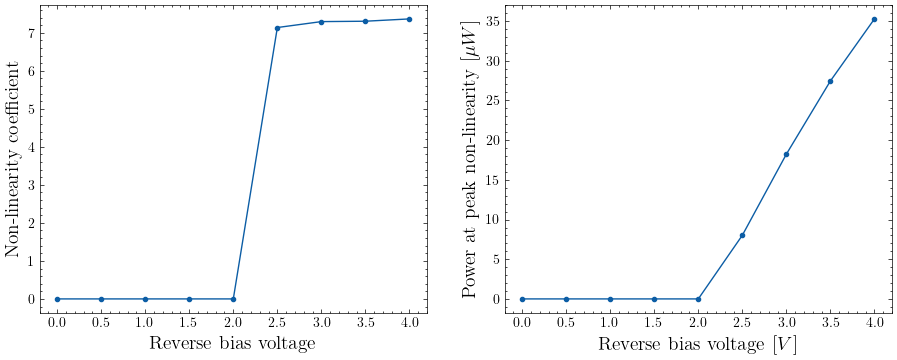

PLOTS FOR RESISTANCE 3,012,000
[0.019731492026511886, 36.899715833239995, 956.759485725431]
Fit with resistance 3012000 and voltage 0.0 was not completely successful.
[0.016428678848252425, 33.430765361221994, 967.4075196161731]
[0.016917157013029857, 30.897668669940956, 975.032496678214]
[0.020217675460950345, 30.592790049379193, 976.3580719207575]
[0.024151496289294878, 31.66896759622473, 972.7757337147991]
[0.02638224842806173, 32.13919087022677, 971.2348734758693]
[0.02843056333448445, 33.09905606241903, 968.0231510867025]
[0.031070726859707014, 34.62334790286424, 962.9394951232695]
Fit with resistance 3012000 and voltage -3.5 was not completely successful.
[0.03300400339164767, 35.87479667888096, 958.7687899162523]


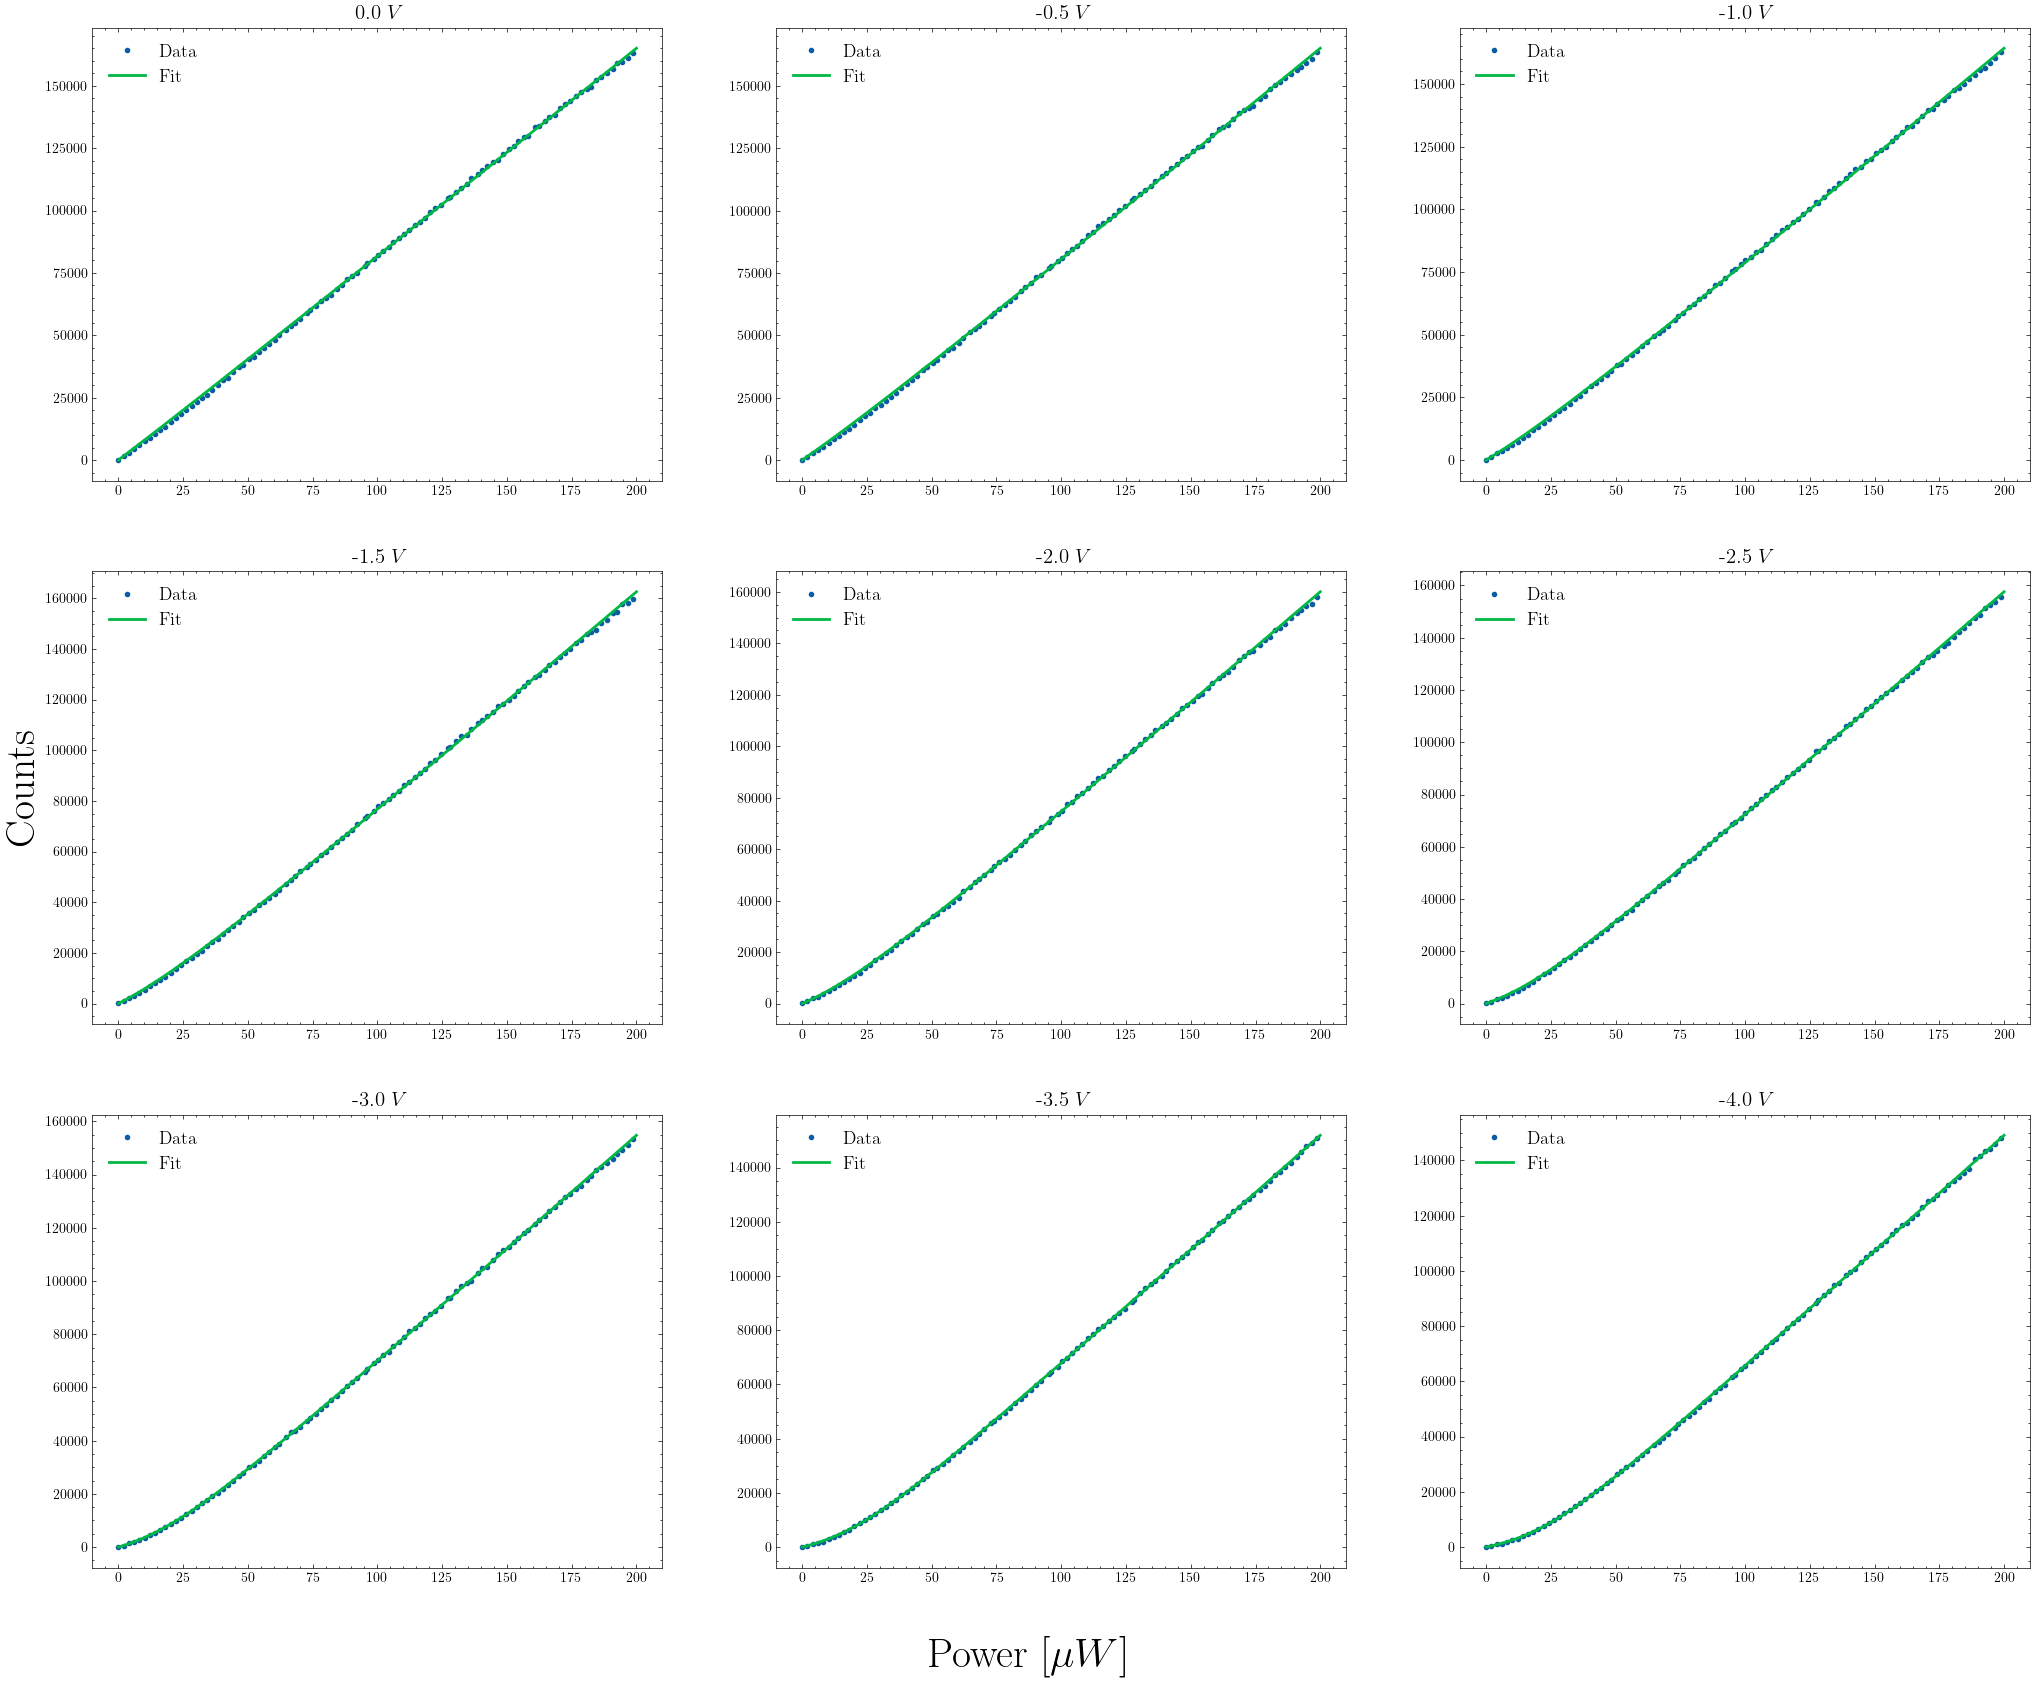

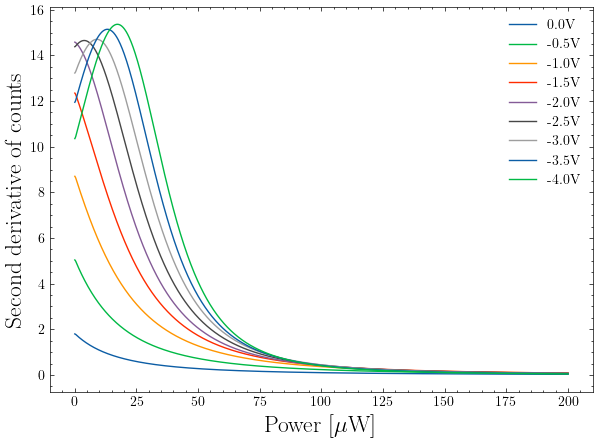

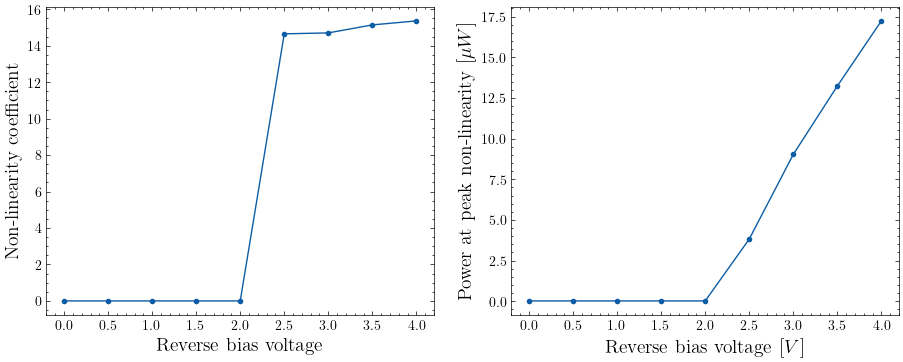

PLOTS FOR RESISTANCE 10,000,000
[0.0047848853731383804, 33.12367867170416, 953.4602551354939]
Fit with resistance 10000000 and voltage 0.0 was not completely successful.
[0.007644222736916753, 30.83916019085754, 957.7779422161639]
[0.013295077445416163, 30.747097600806594, 958.4188885633224]
Fit with resistance 10000000 and voltage -1.0 was not completely successful.
[0.016346120066085164, 30.26443947254931, 960.1300210234153]
[0.018621854717119874, 29.782567053140983, 961.7352001012465]
[0.020739854997597878, 29.520542599496444, 962.6342991719647]
[0.02249079110581381, 29.51466961138764, 962.6669668660174]
[0.02383080244558946, 29.367300944344557, 963.1697813819255]
[0.02488875539621226, 29.36842679277638, 963.1696025183647]
Fit with resistance 10000000 and voltage -4.0 was not completely successful.


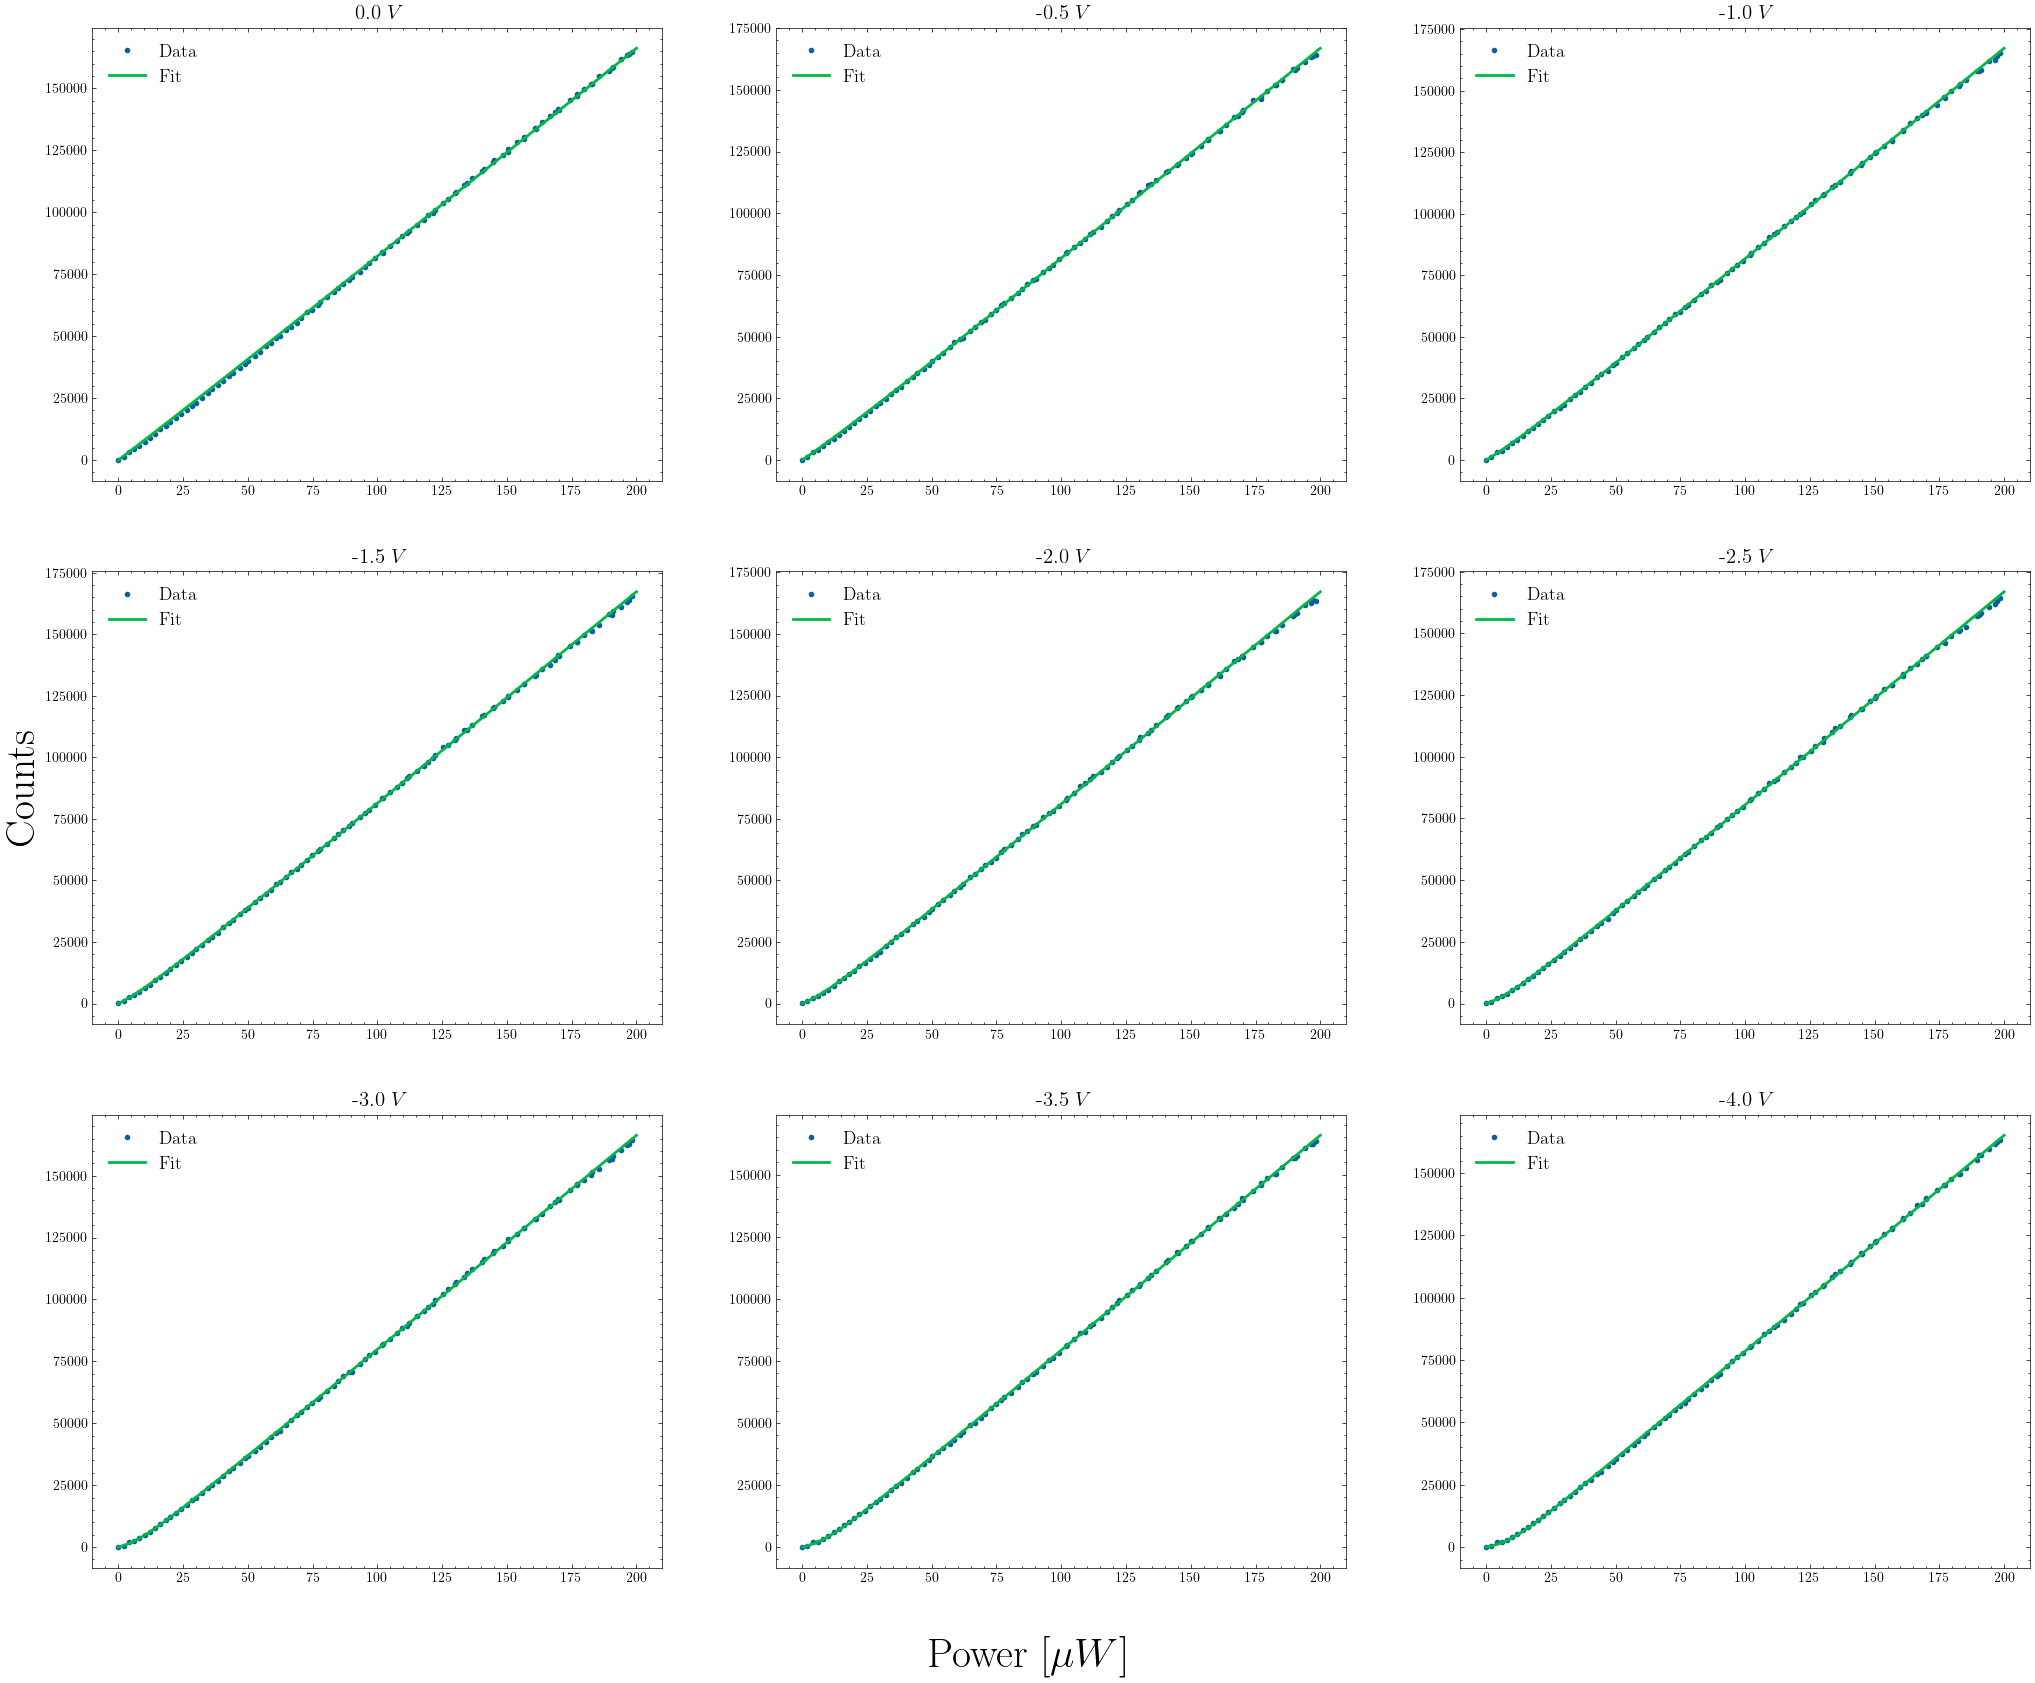

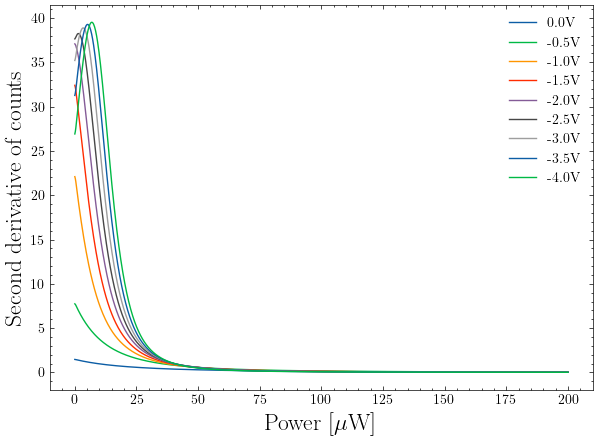

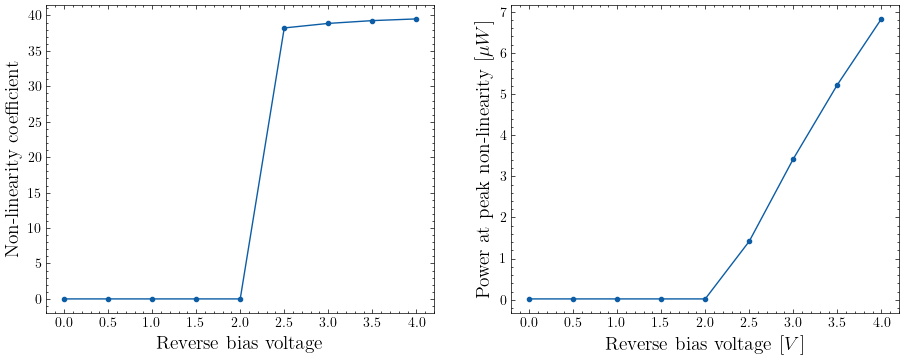

In [73]:
for idx in range(1, len(resistances)):
    max_deriv, max_nl_voltage = fit_and_plot_for_resistance(data_dict, voltagelist, resistances[idx], [0.01, 13.5, 1000], softloss=True, initial_guesses_feedback=True)
    max_deriv_res.append(max_deriv)
    max_nl_voltage_res.append(max_nl_voltage)

Text(0, 0.5, 'Reverse voltage with max non-linearity')

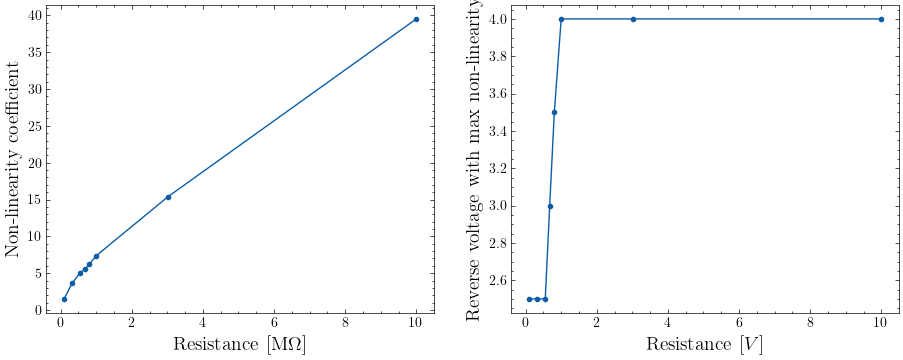

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 4))
ax1.plot(np.array(resistances[1:]) * 1e-6, max_deriv_res, '.-')
ax1.set_xlabel(r"Resistance [M$\Omega$]", fontsize=14)
ax1.set_ylabel(r"Non-linearity coefficient", fontsize=14)
ax2.plot(np.array(resistances[1:]) * 1e-6, np.abs(max_nl_voltage_res), '.-')
ax2.set_xlabel(r"Resistance [$V$]", fontsize=14)
ax2.set_ylabel(r"Reverse voltage with max non-linearity", fontsize=14)

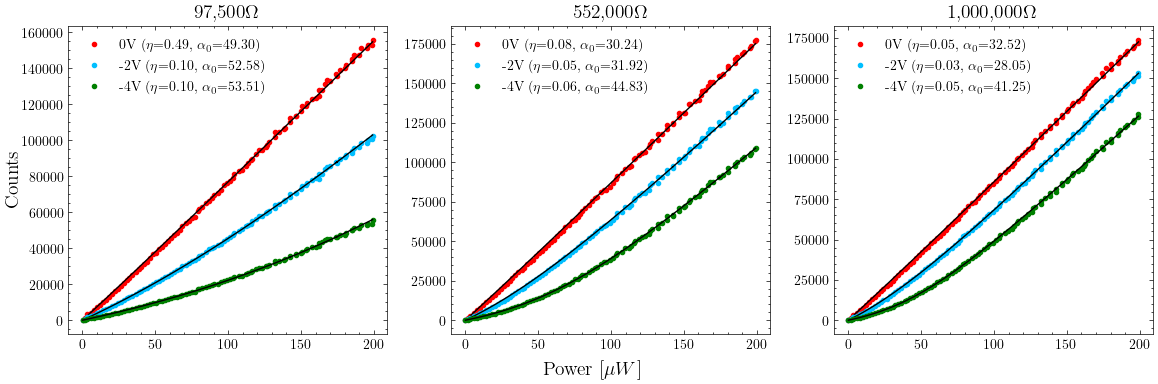

In [125]:
fig, axs = plt.subplots(1, 3, figsize=(14, 4))
colors = ["red", "deepskyblue", "green"]
for i, res_idx in enumerate([1, 3, 6]):
    for j, voltage_idx in enumerate([0, 4, 8]):
        fk_fit = FKFit(data_dict[0]["M_power"], resistances[res_idx] * 1e-6, 3.5e-3, 2.99792458e5 / 321.5, 0.3, 298, voltagelist[voltage_idx])
        fit_input = FitInput(data_dict[0]["M_power"], data_dict[resistances[res_idx]]["counts"][:, voltage_idx], np.sqrt(data_dict[0]["counts"][:, voltage_idx]), fk_fit.FK_fit_power_scaled, [0.05, 30, 1000])
        fit_result = perform_fit_rounds(fit_input, opt_rounds=10, softloss=False)

        axs[i].plot(fit_input.xdata, fit_input.ydata, '.', label=fr"{voltagelist[voltage_idx]:.0f}V   ($\eta$={fit_result.parameters[0]:.2f}, $\alpha_0$={fit_result.parameters[1]:.2f})", color=colors[j])
        axs[i].plot(fit_input.xdata, fit_input.fit_func(fit_input.xdata, *fit_result.parameters), color="black")
    axs[i].set_title(f"{resistances[res_idx]:,}$\Omega$", fontsize=14)
    axs[i].legend()
fig.text(0.5, 0.01, r"Power [$\mu W$]", ha="center", fontsize=14)
fig.text(0.08, 0.5, "Counts", va="center", rotation="vertical", fontsize=14)
plt.show()